# Costs of healthcare

Why? Deliver value-based care with improved outcomes at reduced cost, through the use of analytics and decision support, including patient reported outcomes and medication adherence. The more efficiently resources are allocated in the healthcare system, the more patients are able to access these resources, including physicians, equipment, supplies, and time.

Sequence of events:

1) Merging datasets

2) Cleaning merged datasets

3) Feature engineering

4) Data Visualisation

5) Fitting Random Forest

6) Feature Engineering 2

7) Feature Engineering for Elastic Net Regression 

8) Elastic Net Regression


P.S.: The code below was ported over from a python script. The original coding was conducted using Pycharm IDE.

### Merging Datasets

In [1]:
"""Importing data wrangling and cleaning packages"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import pytz

In [2]:
"""Insert working directory here"""
print(os.getcwd()) #prints current working directory
file_path = '/Users/hydraze/Google Drive/Applications/Data science/Research/Holmusk/Task/datasciencepositionatholmusk'
os.chdir(file_path) #sets working directory to wherever you want

/Users/hydraze/Google Drive/Applications/Data science/Research/Holmusk/Task/datasciencepositionatholmusk/scripts


In [3]:
"""creating dictionary to define data types when loading into pandas df. For speed and efficiency downstream"""

data_types = {'gender':'category',
              'race':'category',
              'resident_status':'category',
              'medical_history_1':'category',
              'medical_history_2':'category',
              'medical_history_3':'category',
              'medical_history_4':'category',
              'medical_history_5':'category',
              'medical_history_6':'category',
              'medical_history_7':'category',
              'preop_medication_1':'category',
              'preop_medication_2':'category',
              'preop_medication_3':'category',
              'preop_medication_4':'category',
              'preop_medication_5':'category',
              'preop_medication_6':'category',
              'symptom_1':'category',
              'symptom_2':'category',
              'symptom_3':'category',
              'symptom_4':'category',
              'symptom_5':'category',
              }
#Converting variables into categories will help with finding wrongly keyed data too.


"""Loading dataset"""
bill_amount = pd.read_csv('./data/bill_amount.csv', dtype = data_types) #the ./data/ is because I put the datasets in a "data" file
ids = pd.read_csv('./data/bill_id.csv', dtype = data_types, parse_dates= ['date_of_admission'])
clinical_data = pd.read_csv('./data/clinical_data.csv', dtype = data_types, parse_dates= ['date_of_admission', 'date_of_discharge'])
demographics = pd.read_csv('./data/demographics.csv', dtype = data_types, parse_dates= ['date_of_birth'])
#3000 assumed to be baseline because there should not be multiple entries in demographics

In [4]:
print(bill_amount.head(), "\n")
print(ids.head(), "\n")
print(clinical_data.head(), "\n")
print(demographics.head(), "\n")
print("Number of patients =", len(demographics))

#3,000 patients assumed to be baseline because there should not be multiple entries in demographics. Here is where
#I look at what variables are in the dataset

      bill_id       amount
0    40315104  1552.634830
1  2660045161  1032.011951
2  1148334643  6469.605351
3  3818426276   755.965425
4  9833541918   897.347816 

      bill_id                        patient_id date_of_admission
0  7968360812  1d21f2be18683991eb93d182d6b2d220        2011-01-01
1  6180579974  62bdca0b95d97e99e1c712048fb9fd09        2011-01-01
2  7512568183  1d21f2be18683991eb93d182d6b2d220        2011-01-01
3  3762633379  62bdca0b95d97e99e1c712048fb9fd09        2011-01-01
4  7654730355  1d21f2be18683991eb93d182d6b2d220        2011-01-01 

                                 id date_of_admission date_of_discharge  \
0  1d21f2be18683991eb93d182d6b2d220        2011-01-01        2011-01-11   
1  62bdca0b95d97e99e1c712048fb9fd09        2011-01-01        2011-01-11   
2  c85cf97bc6307ded0dd4fef8bad2fa09        2011-01-02        2011-01-13   
3  e0397dd72caf4552c5babebd3d61736c        2011-01-02        2011-01-14   
4  94ade3cd5f66f4584902554dff170a29        2011-01-08        20

In [5]:
"""Checking for duplicates"""
print("Number of rows in demographics before dropping duplicates = ", len(demographics))
demographics.drop_duplicates(inplace = True)
print("Number of rows in demographics after dropping duplicates = ", len(demographics))

print("Number of rows in clinical data before dropping duplicates = ", len(clinical_data))
clinical_data.drop_duplicates(inplace = True)
print("Number of rows in clinical data after dropping duplicates = ", len(clinical_data))

print("Number of rows in ids before dropping duplicates = ", len(ids))
ids.drop_duplicates(inplace = True)
print("Number of rows in ids after dropping duplicates = ", len(ids))

print("Number of rows in bill amounts before dropping duplicates = ", len(bill_amount))
bill_amount.drop_duplicates(inplace = True)
print("Number of rows in bill amounts after dropping duplicates = ", len(bill_amount))


#No duplicates!


Number of rows in demographics before dropping duplicates =  3000
Number of rows in demographics after dropping duplicates =  3000
Number of rows in clinical data before dropping duplicates =  3400
Number of rows in clinical data after dropping duplicates =  3400
Number of rows in ids before dropping duplicates =  13600
Number of rows in ids after dropping duplicates =  13600
Number of rows in bill amounts before dropping duplicates =  13600
Number of rows in bill amounts after dropping duplicates =  13600


In [6]:
"""Checking out if ids are unique, because merging based on ids"""
#patient_id
print("Number of unique patient IDs in bill ids dataset = ",len(ids.patient_id.unique()))
print("Number of unique patient IDs in clinical data dataset = ",len(clinical_data.id.unique()))
print("Number of unique patient IDs in demographics dataset = ",len(demographics.patient_id.unique()))
#all datasets have 3000 unique patient ids

#bill
print("Number of unique bill IDs in bill ids dataset = ", len(ids.bill_id.unique()))
print("Number of unique bill IDs in bill amount dataset = ", len(bill_amount.bill_id.unique()))
#Both datasets have 13600 unique bills


Number of unique patient IDs in bill ids dataset =  3000
Number of unique patient IDs in clinical data dataset =  3000
Number of unique patient IDs in demographics dataset =  3000
Number of unique bill IDs in bill ids dataset =  13600
Number of unique bill IDs in bill amount dataset =  13600


In [7]:
"""Merging datasets"""
df_patients = demographics.merge(clinical_data, how = 'left', left_on = 'patient_id', right_on = 'id') 
#tested with inner & outer join first
df_patients.pop('id') #removing duplicate columns
data_counts = df_patients.groupby('patient_id').count() #identifying counts of data per patient_id
print("Number of rows for merged demographics and clinical data =", len(df_patients)) #3,400 rows, hence following
#clinical data. 
print("Number of rows for data counts =", len(data_counts)) #3,000 patients, in contrast to 3,400 rows of clinical
#data. Suggests multiple admissions for certain patients.

Number of rows for merged demographics and clinical data = 3400
Number of rows for data counts = 3000


In [8]:
"""Merging of datasets for bills"""
df_bills = ids.merge(bill_amount, how = 'left', on = 'bill_id') #tested with inner & outer join first
data_counts = df_bills.groupby('bill_id').count() #identifying counts of data per bill_id
print("Number of rows for bill ids and bill amounts =", len(df_bills)) #13,600 rows. Hence exact matching of the two dfs
print("Number of rows for data counts =", len(data_counts)) #13,600 rows.

"""Merging of the two merged datasets"""
df_full = df_patients.merge(df_bills, how = 'left', on = ['patient_id', 'date_of_admission']) #tested with inner & outer join first
print("Number of rows for combined dataset =", len(df_bills)) #13,600. One row one bill id
print(demographics.patient_id[0]) #picked first patient_id for testing
testing = df_full.loc[df_full.patient_id == "fa2d818b2261e44e30628ad1ac9cc72c", :] #testing to see if left join was done correctly

print("Number of unique patients =",len(df_full.patient_id.unique())) #3000 patients confirmed
print("Number of unique bills", len(df_full.bill_id.unique())) #13600 bills
col_names = df_full.columns

df_full.drop('bill_id', axis = 1, inplace = True) #Because bill_id is not needed anymore.

Number of rows for bill ids and bill amounts = 13600
Number of rows for data counts = 13600
Number of rows for combined dataset = 13600
fa2d818b2261e44e30628ad1ac9cc72c
Number of unique patients = 3000
Number of unique bills 13600


In [9]:
"""Checking description of all variables"""
description = df_full.describe(include = 'all')
description

,patient_id,gender,race,resident_status,date_of_birth,date_of_admission,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,...,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height,amount
count,13600,13600,13600,13600,13600,13600,13600,13600,12668,13600,...,13600,13600,13600,13600,13600.000000,13600.000000,13600.000000,13600.000000,13600.000000,13600.000000
unique,3000,4,6,4,2746,1450,1532,2,2,4,...,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN
top,4e46fddfa404b306809c350aecbf0f6a,Female,Chinese,Singaporean,1975-08-20 00:00:00,2014-05-24 00:00:00,2011-10-23 00:00:00,0,0.0,0,...,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN
freq,16,6344,7240,8112,20,36,36,11300,8724,8704,...,9008,7408,9880,7164,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,1930-01-20 00:00:00,2011-01-01 00:00:00,2011-01-11 00:00:00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,1990-12-15 00:00:00,2015-12-28 00:00:00,2016-01-11 00:00:00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,14.469882,27.431529,99.489706,78.748441,165.084412,5464.767783
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.747130,2.463572,15.252770,10.973866,6.972908,7717.479509
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,9.100000,19.700000,52.000000,48.000000,151.000000,79.496707
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,13.200000,25.800000,88.000000,71.200000,160.000000,950.689008


From the descriptions above, some patient ids appeared 16 times, there are 4 genders, 6 races, 4 resident statuses, medical history 3 has 4 categories, min bill amount is 79, while max is 81849. Should be good to look at the distribution of the bill amounts. Data ranges from 2011-2016 for date of admission. Missing values present in medical_history_2 and medical_history_5

### Data Cleaning

In [10]:
#4 different genders
print("Unique genders =", df_full.gender.unique()) #shows Female, Male, f, m
df_full.loc[df_full.gender == 'f', 'gender'] = 'Female'
df_full.loc[df_full.gender == 'm', 'gender'] = 'Male'
print("Unique genders =", df_full.gender.unique())
df_full.gender.cat.remove_unused_categories(inplace = True)
df_full.gender #check cleaning done correctly


Unique genders = [Female, f, Male, m]
Categories (4, object): [Female, f, Male, m]
Unique genders = [Female, Male]
Categories (2, object): [Female, Male]


0        Female
1        Female
2        Female
3        Female
4        Female
5        Female
6        Female
7        Female
8          Male
9          Male
10         Male
11         Male
12         Male
13         Male
14         Male
15         Male
16         Male
17         Male
18         Male
19         Male
20         Male
21         Male
22         Male
23         Male
24       Female
25       Female
26       Female
27       Female
28         Male
29         Male
          ...  
13570    Female
13571    Female
13572      Male
13573      Male
13574      Male
13575      Male
13576    Female
13577    Female
13578    Female
13579    Female
13580    Female
13581    Female
13582    Female
13583    Female
13584    Female
13585    Female
13586    Female
13587    Female
13588      Male
13589      Male
13590      Male
13591      Male
13592    Female
13593    Female
13594    Female
13595    Female
13596      Male
13597      Male
13598      Male
13599      Male
Name: gender, Length: 13

In [11]:
#6 different races
print("Unique races =", df_full.race.unique())
df_full.loc[df_full.race == 'chinese', 'race'] = 'Chinese'
df_full.loc[df_full.race == 'India', 'race'] = 'Indian'
print("Unique races =", df_full.race.unique())
df_full.race.cat.remove_unused_categories(inplace = True)
df_full.race #check cleaning done correctly

Unique races = [Indian, Chinese, Malay, chinese, India, Others]
Categories (6, object): [Indian, Chinese, Malay, chinese, India, Others]
Unique races = [Indian, Chinese, Malay, Others]
Categories (4, object): [Indian, Chinese, Malay, Others]


0         Indian
1         Indian
2         Indian
3         Indian
4        Chinese
5        Chinese
6        Chinese
7        Chinese
8        Chinese
9        Chinese
10       Chinese
11       Chinese
12       Chinese
13       Chinese
14       Chinese
15       Chinese
16         Malay
17         Malay
18         Malay
19         Malay
20       Chinese
21       Chinese
22       Chinese
23       Chinese
24       Chinese
25       Chinese
26       Chinese
27       Chinese
28         Malay
29         Malay
          ...   
13570      Malay
13571      Malay
13572    Chinese
13573    Chinese
13574    Chinese
13575    Chinese
13576     Others
13577     Others
13578     Others
13579     Others
13580      Malay
13581      Malay
13582      Malay
13583      Malay
13584      Malay
13585      Malay
13586      Malay
13587      Malay
13588     Indian
13589     Indian
13590     Indian
13591     Indian
13592    Chinese
13593    Chinese
13594    Chinese
13595    Chinese
13596    Chinese
13597    Chine

In [12]:
#4 residential statuses
print("Unique residential statuses =",df_full.resident_status.unique())
df_full.loc[df_full.resident_status == 'Singapore citizen', 'resident_status'] = 'Singaporean'
print("Unique residential statuses =", df_full.resident_status.unique())
df_full.resident_status.cat.remove_unused_categories(inplace = True)
df_full.resident_status #check cleaning done correctly

Unique residential statuses = [Singaporean, Singapore citizen, PR, Foreigner]
Categories (4, object): [Singaporean, Singapore citizen, PR, Foreigner]
Unique residential statuses = [Singaporean, PR, Foreigner]
Categories (3, object): [Singaporean, PR, Foreigner]


0        Singaporean
1        Singaporean
2        Singaporean
3        Singaporean
4        Singaporean
5        Singaporean
6        Singaporean
7        Singaporean
8        Singaporean
9        Singaporean
10       Singaporean
11       Singaporean
12       Singaporean
13       Singaporean
14       Singaporean
15       Singaporean
16       Singaporean
17       Singaporean
18       Singaporean
19       Singaporean
20       Singaporean
21       Singaporean
22       Singaporean
23       Singaporean
24                PR
25                PR
26                PR
27                PR
28       Singaporean
29       Singaporean
            ...     
13570    Singaporean
13571    Singaporean
13572    Singaporean
13573    Singaporean
13574    Singaporean
13575    Singaporean
13576    Singaporean
13577    Singaporean
13578    Singaporean
13579    Singaporean
13580             PR
13581             PR
13582             PR
13583             PR
13584    Singaporean
13585    Singaporean
13586    Sing

In [13]:
#4 categories in medical history 3
print("Counts of categories under medical history 3 =", "\n",df_full.medical_history_3.value_counts()) 
#0 is likely to indicate absence of medical condition, as it is way higher than
print("Unique categories of medical history 3 =", df_full.medical_history_3.unique())
df_full.loc[df_full.medical_history_3 == 'No', 'medical_history_3'] = '0'
df_full.loc[df_full.medical_history_3 == 'Yes', 'medical_history_3'] = '1'
print("Unique categories of medical history 3 =", df_full.medical_history_3.unique())
df_full.medical_history_3.cat.remove_unused_categories(inplace = True)
df_full.medical_history_3 #check cleaning done correctly

Counts of categories under medical history 3 = 
 0      8704
No     3044
1      1392
Yes     460
Name: medical_history_3, dtype: int64
Unique categories of medical history 3 = [0, No, 1, Yes]
Categories (4, object): [0, No, 1, Yes]
Unique categories of medical history 3 = [0, 1]
Categories (2, object): [0, 1]


0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       0
25       0
26       0
27       0
28       0
29       0
        ..
13570    1
13571    1
13572    0
13573    0
13574    0
13575    0
13576    0
13577    0
13578    0
13579    0
13580    0
13581    0
13582    0
13583    0
13584    0
13585    0
13586    0
13587    0
13588    1
13589    1
13590    1
13591    1
13592    0
13593    0
13594    0
13595    0
13596    0
13597    0
13598    0
13599    0
Name: medical_history_3, Length: 13600, dtype: category
Categories (2, object): [0, 1]

In [14]:
"""Checking Missing values in all variables"""
print("Sum of all NAs =\n", df_full.isna().sum()) #medical_history_5 has 1216 missing values, medical_history_2 has 932 missing values.
na_df = df_full.loc[((df_full.medical_history_2.isna()) | (df_full.medical_history_5.isna())), :]
print("Number of patients with NA in medical history 2 or 5 =", len(na_df.patient_id.unique())) 
#494 patients with missing values! that's approx 13% of all patients. >10% of all patients, so need to impute.

#checking descriptions of those with NAs, and those without NAs
na_describe = na_df.describe(include = 'all')
na_describe

Sum of all NAs =
 patient_id               0
gender                   0
race                     0
resident_status          0
date_of_birth            0
date_of_admission        0
date_of_discharge        0
medical_history_1        0
medical_history_2      932
medical_history_3        0
medical_history_4        0
medical_history_5     1216
medical_history_6        0
medical_history_7        0
preop_medication_1       0
preop_medication_2       0
preop_medication_3       0
preop_medication_4       0
preop_medication_5       0
preop_medication_6       0
symptom_1                0
symptom_2                0
symptom_3                0
symptom_4                0
symptom_5                0
lab_result_1             0
lab_result_2             0
lab_result_3             0
weight                   0
height                   0
amount                   0
dtype: int64
Number of patients with NA in medical history 2 or 5 = 494


,patient_id,gender,race,resident_status,date_of_birth,date_of_admission,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,...,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height,amount
count,2008,2008,2008,2008,2008,2008,2008,2008,1076,2008,...,2008,2008,2008,2008,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000
unique,494,2,4,3,485,428,447,2,2,2,...,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN
top,abf891f9ac85c168ae471c86fcd8fb46,Female,Chinese,Singaporean,1975-05-20 00:00:00,2012-12-24 00:00:00,2012-01-19 00:00:00,0,0.0,0,...,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN
freq,8,1032,1244,1636,8,16,12,1696,812,1748,...,1336,1028,1468,1040,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,1930-07-18 00:00:00,2011-01-07 00:00:00,2011-01-17 00:00:00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,1986-12-11 00:00:00,2015-12-28 00:00:00,2016-01-11 00:00:00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,14.537849,27.487450,99.330677,78.104183,164.800797,5339.453292
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.750815,2.345202,15.007529,10.612127,6.617469,7509.111659
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,9.100000,20.400000,52.000000,49.500000,151.000000,228.234099
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,13.300000,25.800000,89.000000,70.500000,160.000000,926.819483


In [15]:
#Identifying traits of patients without NAs and compare to patients with NAs
not_na_df = df_full[((df_full.medical_history_2.notna()) & df_full.medical_history_5.notna())] #not na for both medical history
not_na_describe = not_na_df.describe(include = 'all')
not_na_describe.head()

,patient_id,gender,race,resident_status,date_of_birth,date_of_admission,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,...,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height,amount
count,11592,11592,11592,11592,11592,11592,11592,11592,11592,11592,...,11592,11592,11592,11592,11592.0,11592.0,11592.0,11592.0,11592.0,11592.0
unique,2608,2,4,3,2406,1367,1443,2,2,2,...,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN
top,4e46fddfa404b306809c350aecbf0f6a,Male,Chinese,Singaporean,1962-11-03 00:00:00,2014-05-24 00:00:00,2011-10-23 00:00:00,0,0.0,0,...,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN
freq,16,5816,7420,9260,16,32,32,9604,7912,10000,...,7672,6380,8412,6124,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,1930-01-20 00:00:00,2011-01-01 00:00:00,2011-01-11 00:00:00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Comparing between variables of those with NAs and those who do not have NAs was not conclusive, because they seemed to share similar proportions and distributions for all variables. Carry on to impute missing values with 0s because by definition, because of two reasons. 

1) 0 is the most likely outcome, and 2) NAs tend to be synonymous with 0 (although it might not be true for this dataset)

In [16]:
#Change NAs to 0, which is the median for both variables
df_full[['medical_history_2', 'medical_history_5']] = df_full[['medical_history_2', 'medical_history_5']].astype(np.number)
#Need to convert back to number because it was loaded as a categorical variable.
df_full.loc[df_full.medical_history_2.isna(), 'medical_history_2'] = 0
df_full.loc[df_full.medical_history_5.isna(), 'medical_history_5'] = 0
print(df_full.isna().any()) #Checking if any of the columns have na values
df_full[['medical_history_2', 'medical_history_5']] = df_full[['medical_history_2', 'medical_history_5']].astype('category')
#convert back to category
print(df_full.medical_history_2.cat.categories)

patient_id            False
gender                False
race                  False
resident_status       False
date_of_birth         False
date_of_admission     False
date_of_discharge     False
medical_history_1     False
medical_history_2     False
medical_history_3     False
medical_history_4     False
medical_history_5     False
medical_history_6     False
medical_history_7     False
preop_medication_1    False
preop_medication_2    False
preop_medication_3    False
preop_medication_4    False
preop_medication_5    False
preop_medication_6    False
symptom_1             False
symptom_2             False
symptom_3             False
symptom_4             False
symptom_5             False
lab_result_1          False
lab_result_2          False
lab_result_3          False
weight                False
height                False
amount                False
dtype: bool
Float64Index([0.0, 1.0], dtype='float64')


In [17]:
"""Identifying anomalous variables"""
#Checking if dates are in order
print("Number of birthdates after date of admission =", len(df_full.loc[df_full.date_of_birth > df_full.date_of_admission, :])) #No one's D.O.B is after date of admission
print("Number of date of admission after date of discharge =", len(df_full.loc[df_full.date_of_admission > df_full.date_of_discharge, :])) #No one's date of discharge is date of admission

Number of birthdates after date of admission = 0
Number of date of admission after date of discharge = 0


In [18]:
"""Identifying if there are any patients not on ops medication"""
ops = df_full[['preop_medication_1', 'preop_medication_2', 'preop_medication_3', 'preop_medication_4', 'preop_medication_5', 'preop_medication_6']].copy()
ops['total'] = ops.astype(np.number).sum(axis = 1)
print("Max number of operation medication of all patients =", ops.total.max())
print("Min number of operation medication of all patients =", ops.total.min())
ops.loc[ops.total == 0, :] #8 entries without any surgical medication. How many patients are there?

no_ops = df_full.loc[ops.total == 0,:]
print("Number of patients not taking any preop medication =", len(no_ops.patient_id.unique()))

Max number of operation medication of all patients = 6.0
Min number of operation medication of all patients = 0.0
Number of patients not taking any preop medication = 2


Notes: In terms of medications, prior to surgery, an antibiotic may be given to prevent infections at the surgical site. Antibiotics are a category of drugs used to combat bacteria, and they are generally given orally (in pill form), or intravenously (through an IV). 

Retrived from: verywellhealth.com

## End of Pre-processing. Proceed to Data Engineering

### Data Engineering

In [19]:
"""Creation of age variable"""
df_full['year_of_birth'] = df_full.date_of_birth.map(
    lambda x: x.year
) #Extracting year out of date_of_birth variable and store in a newly created year_of_birth variable

df_full['year_of_admission'] = df_full.date_of_admission.map(
    lambda x: x.year
) #Year of admission might be more accurate and useful than year as of 2020 in my opinion.

df_full['age'] = 2020 - df_full.year_of_birth #Birthday in 2020. But might be inaccurate, because what if patients died by 2020.
print("Max age =", df_full.age.max(), ";" , "Min age =", df_full.age.min())
df_full['age_at_admission'] = df_full.year_of_admission - df_full.year_of_birth #Will determine later which age to use
print("Max age at admission =", df_full.age_at_admission.max(), ";", "Min age at admission =", df_full.age_at_admission.min())


Max age = 90 ; Min age = 30
Max age at admission = 85 ; Min age at admission = 22


In [20]:
"""Creating days of admission variables"""
df_full['days_admitted'] = (df_full.date_of_discharge - df_full.date_of_admission).dt.days
print("Max days admitted =", df_full.days_admitted.max(), ";", "Min days admitted =", df_full.days_admitted.min())

Max days admitted = 20 ; Min days admitted = 1


In [21]:
"""Creating BMI variable"""
df_full['bmi'] = df_full.weight/((df_full.height/100)**2)
print("Max bmi =", df_full.bmi.max(), ";", "Min bmi =", df_full.bmi.min())

Max bmi = 46.677348625400576 ; Min bmi = 17.508650519031143


In [22]:
"""Number of bills per admission per patient id"""
num_bills = df_full[['patient_id', 'date_of_admission', 'amount']].groupby(['patient_id','date_of_admission'], 
                                                                           as_index = False).count()
#This is to group bills by patient id, followed by date of admission. here, can count how many bill amounts 
#there are per date of admission

print("Max number of bills =", num_bills.amount.max(), ";", "Min number of bills =", num_bills.amount.min())
#From this, can see that each patient for each admission has 4 bills. Will need to sum all bill amounts per 
#admission

num_bills  = num_bills[['patient_id', 'date_of_admission']].groupby('patient_id', as_index = False).count()
#This will result in number of date of admission per patient. 
print("Number of patient_ids when aggregating date of admission", len(num_bills)) 
#Got back 3000 patients again. On the right track.

num_bills.columns = ['patient_id', 'num_of_admissions'] 
#need to rename column now so that I don't have to rename later.
print("Max number of admissions =", num_bills.num_of_admissions.max(), ";", 
      "Min number of admissions =", num_bills.num_of_admissions.min())

df_full = df_full.merge(num_bills, how = 'left', on = 'patient_id') #will pass num_of_admissions to df_full
#This will tag number of admissions to each participant
print("Counts per number of admission =", df_full.num_of_admissions.value_counts()) 


df_full.num_of_admissions = df_full.num_of_admissions.astype('category')
#convert to categorical variable because more reflective of context. 
#Also, effect on cost is not likely to be linear when considering context.


print(num_bills.patient_id[0])
df_full.loc[df_full.patient_id == "00225710a878eff524a1d13be817e8e2", :] #check to see if the merge was correct

Max number of bills = 4 ; Min number of bills = 4
Number of patient_ids when aggregating date of admission 3000
Max number of admissions = 4 ; Min number of admissions = 1
Counts per number of admission = 1    10484
2     2872
3      228
4       16
Name: num_of_admissions, dtype: int64
00225710a878eff524a1d13be817e8e2


,patient_id,gender,race,resident_status,date_of_birth,date_of_admission,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,...,weight,height,amount,year_of_birth,year_of_admission,age,age_at_admission,days_admitted,bmi,num_of_admissions
11580,00225710a878eff524a1d13be817e8e2,Female,Chinese,Singaporean,1983-01-16,2014-04-10,2014-04-22,0,0.0,0,...,66.9,155.0,79.496707,1983,2014,37,31,12,27.845994,1
11581,00225710a878eff524a1d13be817e8e2,Female,Chinese,Singaporean,1983-01-16,2014-04-10,2014-04-22,0,0.0,0,...,66.9,155.0,1074.885913,1983,2014,37,31,12,27.845994,1
11582,00225710a878eff524a1d13be817e8e2,Female,Chinese,Singaporean,1983-01-16,2014-04-10,2014-04-22,0,0.0,0,...,66.9,155.0,3710.864731,1983,2014,37,31,12,27.845994,1
11583,00225710a878eff524a1d13be817e8e2,Female,Chinese,Singaporean,1983-01-16,2014-04-10,2014-04-22,0,0.0,0,...,66.9,155.0,325.319345,1983,2014,37,31,12,27.845994,1


In [23]:
"""Aggregate sum per admission and discharge; kept in mind patients admitted multiple times"""
bills_per_admission = df_full[['patient_id', 'date_of_admission', 'amount']]
bills_per_admission = bills_per_admission.groupby(['patient_id','date_of_admission'], as_index = False).sum()
#Summing total bills per patient id per admission.

bills_per_admission.columns = ['patient_id', 'date_of_admission', 'amt_per_admission']
df_full = df_full.merge(bills_per_admission, how = 'left', on = ['patient_id','date_of_admission'])
#Same strategy as previous. Merge amount_per_admission to each patient id and date of admission

df_full.pop('amount') #Don't need this anymore
print("Rows of df_full before removal of duplicates =", len(df_full))
df_full.drop_duplicates(inplace = True) #checking for duplicates/error in merging
print("Rows of df_full after removal of duplicates =", len(df_full))
#Returned 3,400 rows, which corresponds to the total number of rows in clinical data at the beginning. This means
#that each row will now have summed bill amounts per admission.

Rows of df_full before removal of duplicates = 13600
Rows of df_full after removal of duplicates = 3400


In [24]:
"""Reorganising final dataset for data visualisation according to demographics and clinical data"""
print(df_full.columns)
df_full = df_full[['patient_id', 'gender', 'race', 'resident_status', 'weight', 'height', 'bmi', 'age',
                   'age_at_admission', 'num_of_admissions', 'days_admitted', 'medical_history_1', 'medical_history_2',
                   'medical_history_3', 'medical_history_4',
                   'medical_history_5', 'medical_history_6', 'medical_history_7','preop_medication_1',
                   'preop_medication_2', 'preop_medication_3', 'preop_medication_4', 'preop_medication_5',
                   'preop_medication_6', 'symptom_1', 'symptom_2', 'symptom_3', 'symptom_4', 'symptom_5', 'lab_result_1',
                   'lab_result_2', 'lab_result_3', 'amt_per_admission']] #Just to reorganise the columns into demographics and clinical info

#'date_of_birth', 'date_of_admission', 'date_of_discharge' not included anymore because age will contain information from
#those variables


Index(['patient_id', 'gender', 'race', 'resident_status', 'date_of_birth',
       'date_of_admission', 'date_of_discharge', 'medical_history_1',
       'medical_history_2', 'medical_history_3', 'medical_history_4',
       'medical_history_5', 'medical_history_6', 'medical_history_7',
       'preop_medication_1', 'preop_medication_2', 'preop_medication_3',
       'preop_medication_4', 'preop_medication_5', 'preop_medication_6',
       'symptom_1', 'symptom_2', 'symptom_3', 'symptom_4', 'symptom_5',
       'lab_result_1', 'lab_result_2', 'lab_result_3', 'weight', 'height',
       'year_of_birth', 'year_of_admission', 'age', 'age_at_admission',
       'days_admitted', 'bmi', 'num_of_admissions', 'amt_per_admission'],
      dtype='object')


In [25]:
"""Looking at description of the cleaned dataset"""
description = df_full.describe(include = 'all')
description

,patient_id,gender,race,resident_status,weight,height,bmi,age,age_at_admission,num_of_admissions,...,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,amt_per_admission
count,3400,3400,3400,3400,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.0,...,3400,3400,3400,3400,3400,3400,3400.000000,3400.000000,3400.000000,3400.000000
unique,3000,2,4,3,NaN,NaN,NaN,NaN,NaN,4.0,...,2,2,2,2,2,2,NaN,NaN,NaN,NaN
top,4e46fddfa404b306809c350aecbf0f6a,Female,Chinese,Singaporean,NaN,NaN,NaN,NaN,NaN,1.0,...,1,1,1,1,1,1,NaN,NaN,NaN,NaN
freq,4,1702,2166,2724,NaN,NaN,NaN,NaN,NaN,2621.0,...,2530,2107,2252,1852,2470,1791,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,78.748441,165.084412,28.958874,59.532941,52.542647,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.469882,27.431529,99.489706,21859.071130
std,NaN,NaN,NaN,NaN,10.975076,6.973678,4.140674,14.615805,14.681475,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.747323,2.463844,15.254453,10155.336753
min,NaN,NaN,NaN,NaN,48.000000,151.000000,17.508651,30.000000,22.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,9.100000,19.700000,52.000000,2946.100354
25%,NaN,NaN,NaN,NaN,71.200000,160.000000,26.156074,47.000000,40.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,13.200000,25.800000,88.000000,14793.370831
50%,NaN,NaN,NaN,NaN,78.900000,165.000000,28.943985,58.000000,51.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.500000,27.400000,100.000000,20180.020614
75%,NaN,NaN,NaN,NaN,86.300000,170.000000,31.713345,72.000000,65.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,15.800000,29.100000,110.000000,26680.292435


## End of Data Engineering. Proceed to Data Visualisation

In [26]:
"""Importing data visualisation packages"""
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
"""Univariate plots. Split into categorical and numerical variables first"""
num_var = df_full.select_dtypes(include=np.number) #numerical variables
cat_var = df_full.select_dtypes(include= 'category') #categorical variables

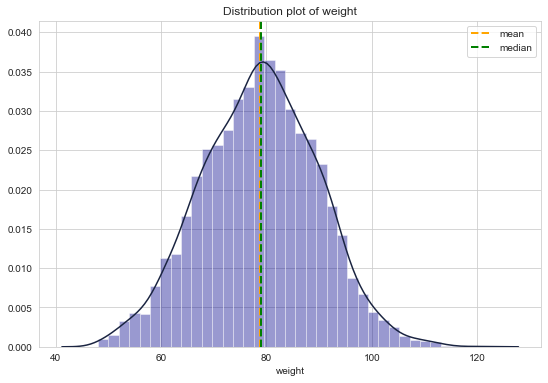

<Figure size 432x288 with 0 Axes>

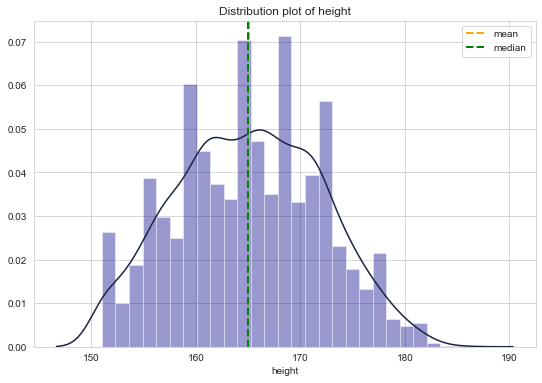

<Figure size 432x288 with 0 Axes>

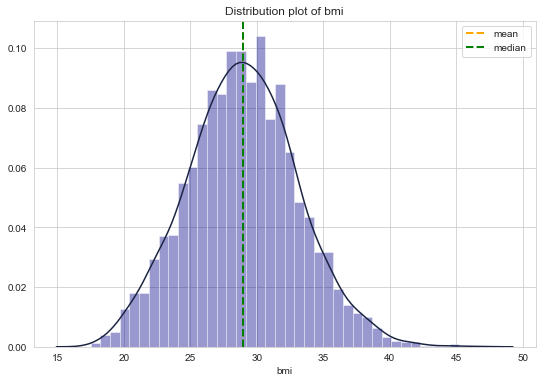

<Figure size 432x288 with 0 Axes>

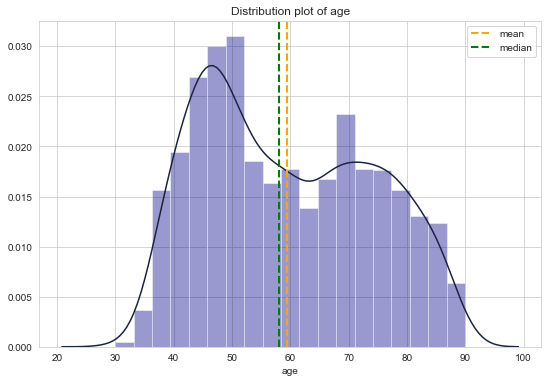

<Figure size 432x288 with 0 Axes>

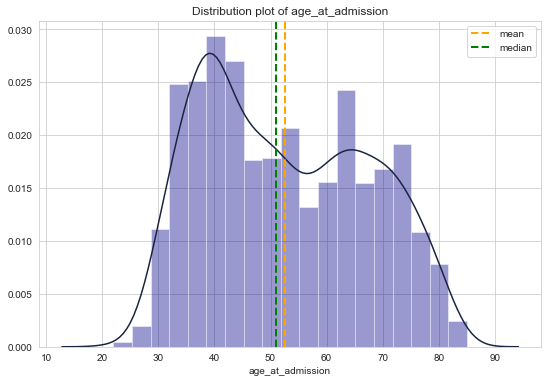

<Figure size 432x288 with 0 Axes>

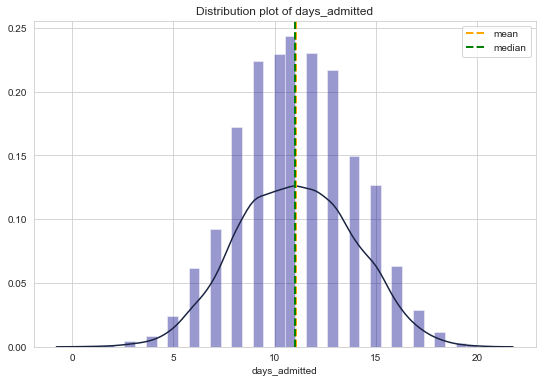

<Figure size 432x288 with 0 Axes>

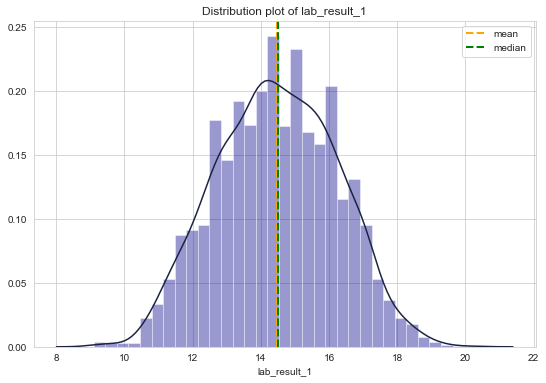

<Figure size 432x288 with 0 Axes>

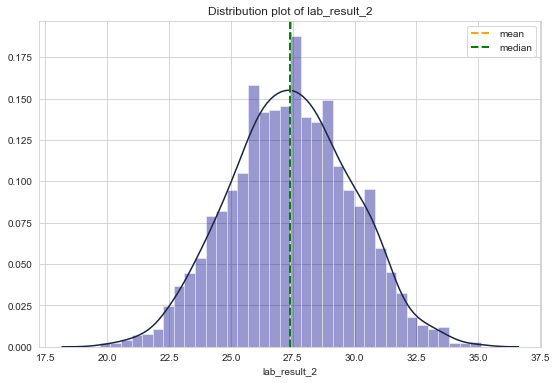

<Figure size 432x288 with 0 Axes>

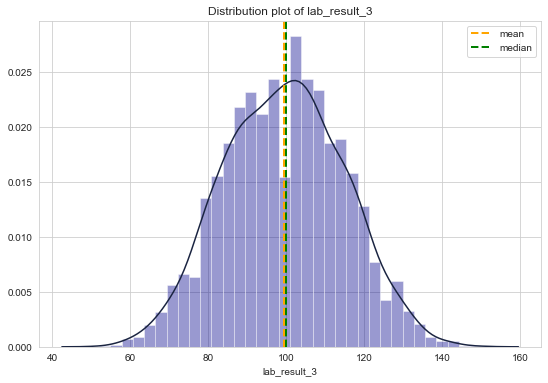

<Figure size 432x288 with 0 Axes>

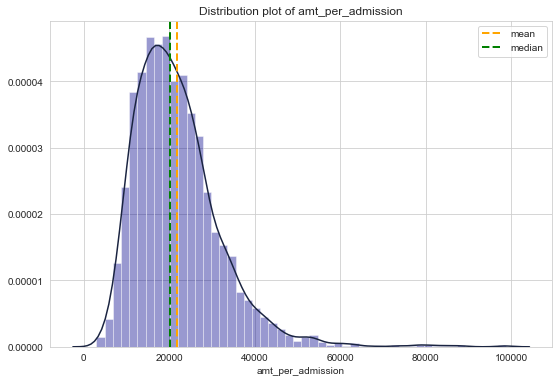

<Figure size 432x288 with 0 Axes>

In [28]:
"""Univariate plots"""
sns.set_style('whitegrid')
sns.set_palette('cubehelix')

for col in num_var.columns:
    plt.figure(figsize = (9,6))
    sns.distplot(num_var[col], axlabel=str(col), hist_kws={'color': 'darkblue'})
    mean = np.mean(num_var[col])
    median = np.median(num_var[col])
    plt.axvline(x=mean, c='orange', ls='--', lw = 2, label='mean')
    plt.axvline(x=median, c='g', ls='--', lw = 2, label='median')
    plt.legend()
    plt.title('Distribution plot of ' + col)
    plt.show()
    plt.clf()


Interestingly, most variables are approximately normally distributed, with the exception of cost, which is quite right skewed. BMI was more normally distributed than either height or weight individually. Age is not normally distributed, but I will leave it alone for now.

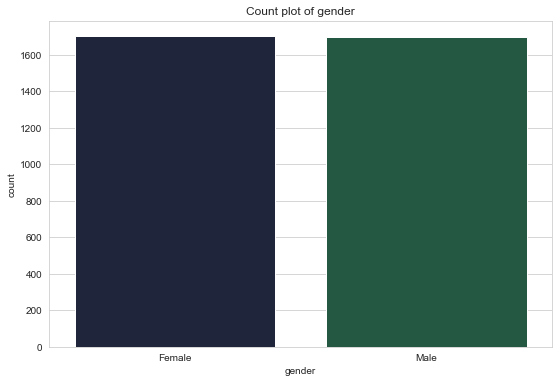

<Figure size 432x288 with 0 Axes>

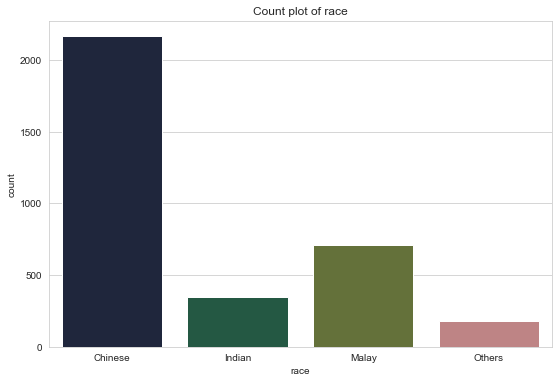

<Figure size 432x288 with 0 Axes>

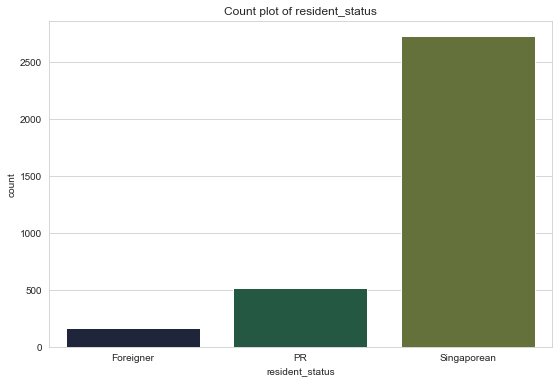

<Figure size 432x288 with 0 Axes>

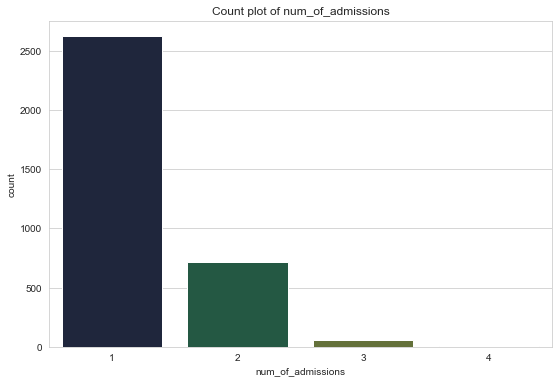

<Figure size 432x288 with 0 Axes>

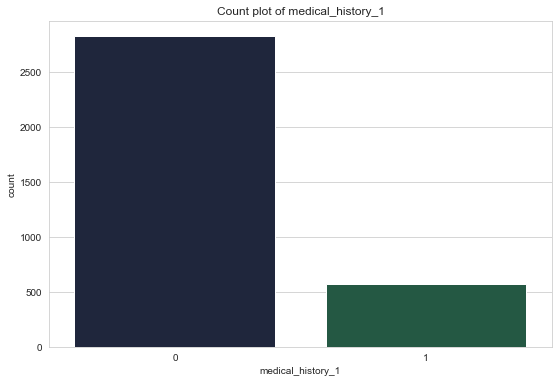

<Figure size 432x288 with 0 Axes>

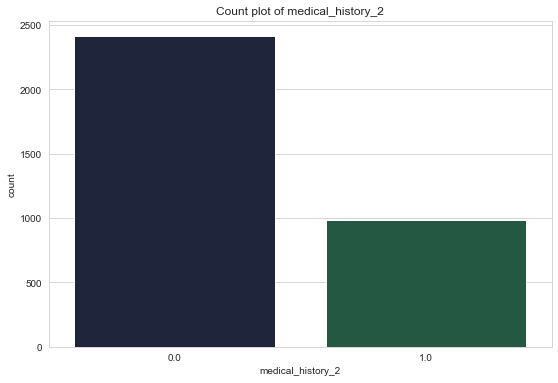

<Figure size 432x288 with 0 Axes>

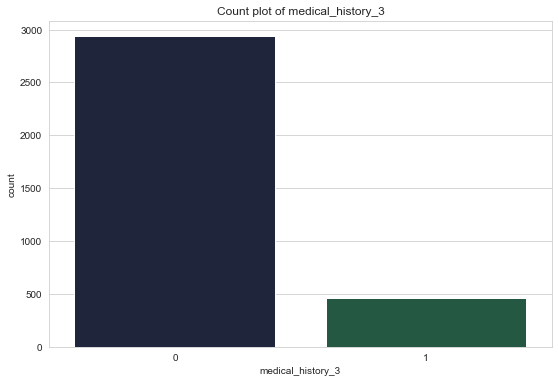

<Figure size 432x288 with 0 Axes>

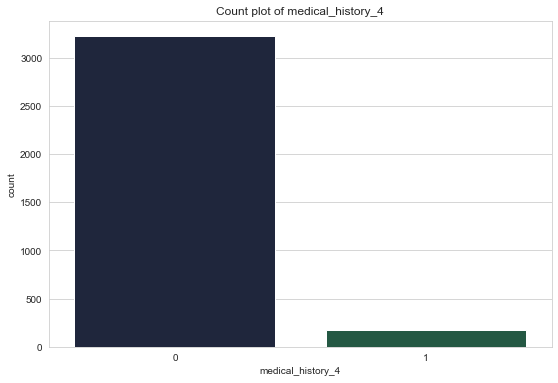

<Figure size 432x288 with 0 Axes>

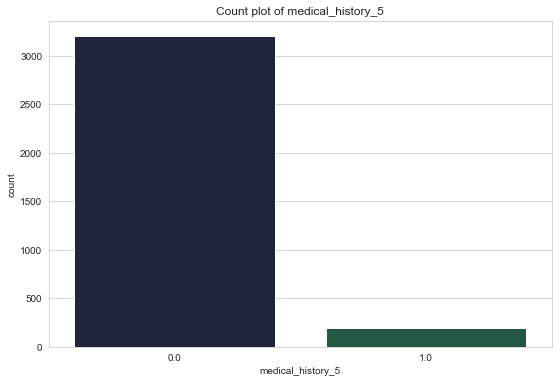

<Figure size 432x288 with 0 Axes>

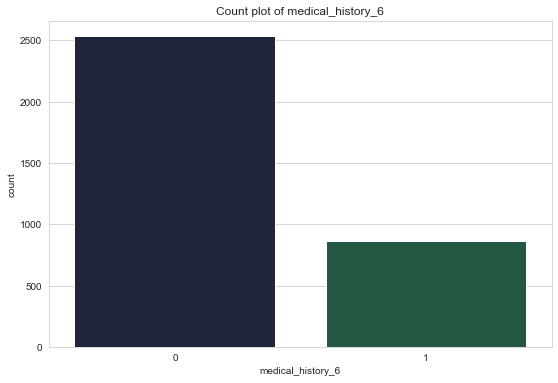

<Figure size 432x288 with 0 Axes>

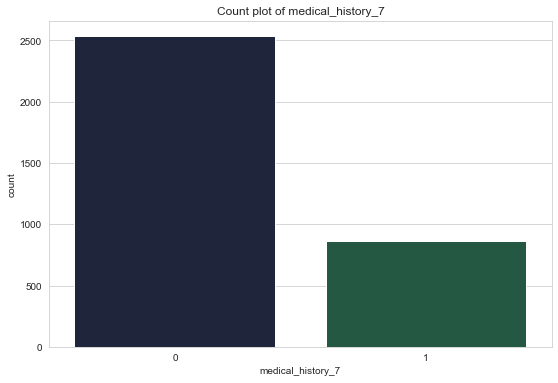

<Figure size 432x288 with 0 Axes>

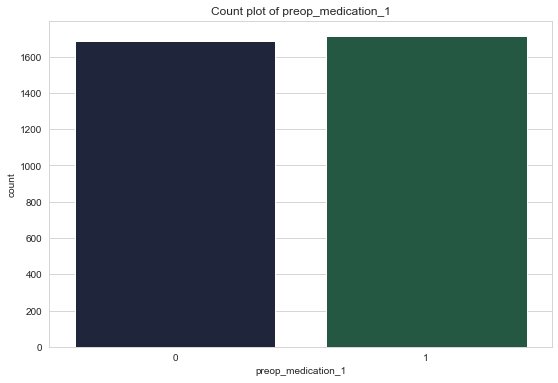

<Figure size 432x288 with 0 Axes>

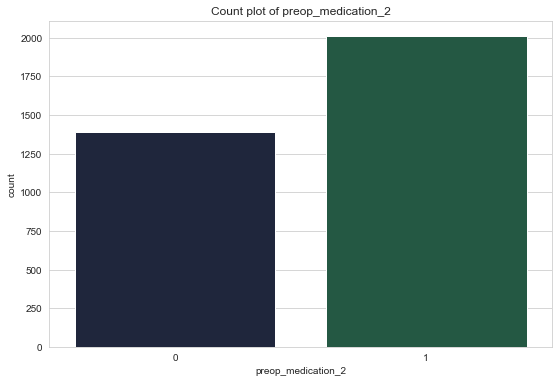

<Figure size 432x288 with 0 Axes>

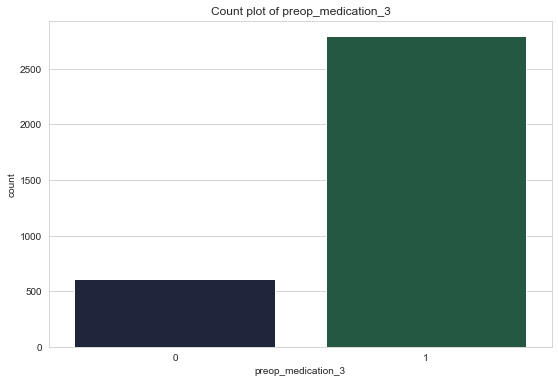

<Figure size 432x288 with 0 Axes>

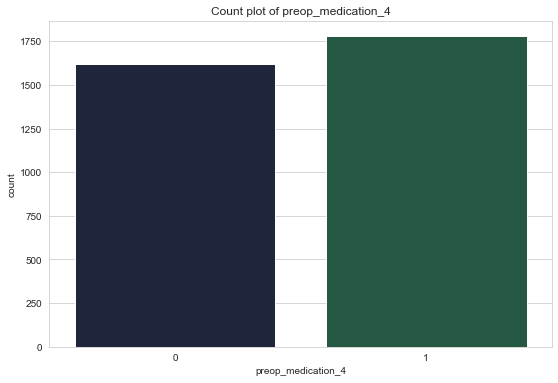

<Figure size 432x288 with 0 Axes>

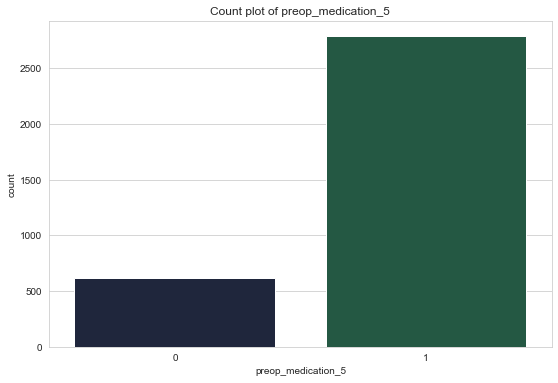

<Figure size 432x288 with 0 Axes>

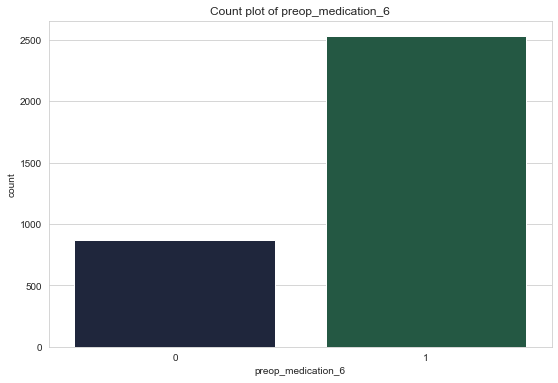

<Figure size 432x288 with 0 Axes>

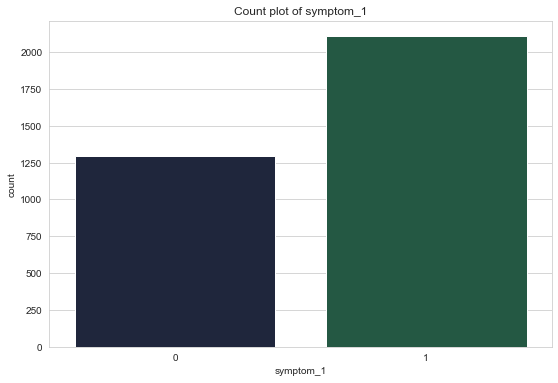

<Figure size 432x288 with 0 Axes>

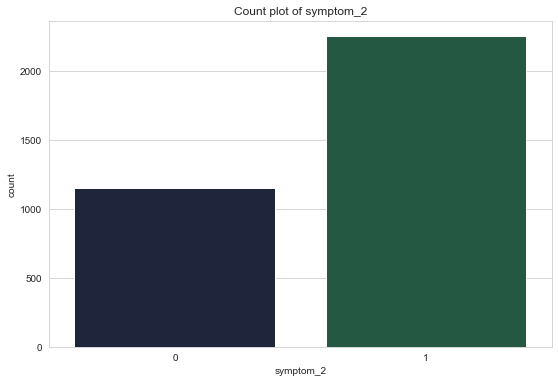

<Figure size 432x288 with 0 Axes>

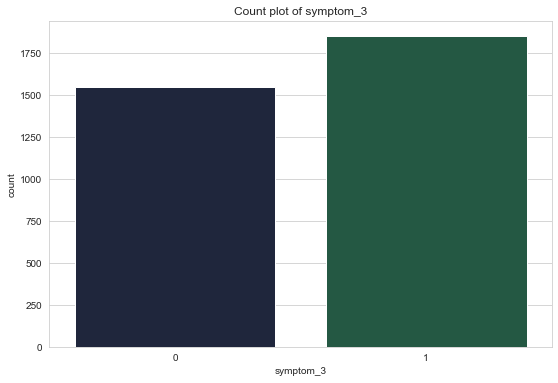

<Figure size 432x288 with 0 Axes>

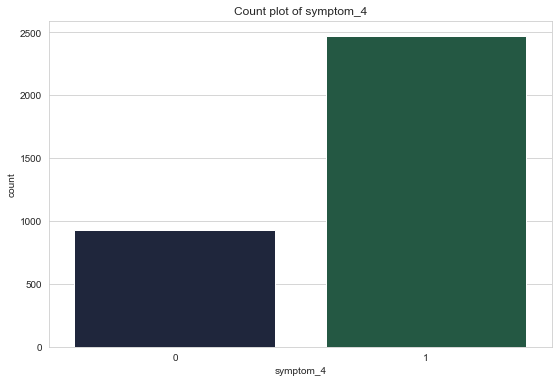

<Figure size 432x288 with 0 Axes>

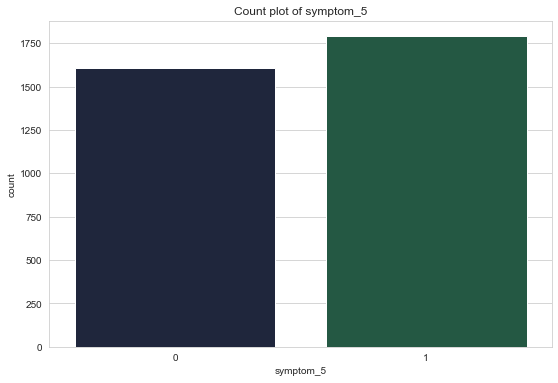

<Figure size 432x288 with 0 Axes>

In [29]:
#Plotting count plots of categorical variables
for col in cat_var.columns:
    plt.figure(figsize = (9,6))
    sns.countplot(cat_var[col])
    plt.title('Count plot of ' + col)
    plt.show()
    plt.clf()

Gender appears to be completely even. Same with pre-op medication 1. Most patients take pre-op medication 3,5 and 6. This is a Singaporean and Chinese-dominated sample. Most patients show symptom 4.

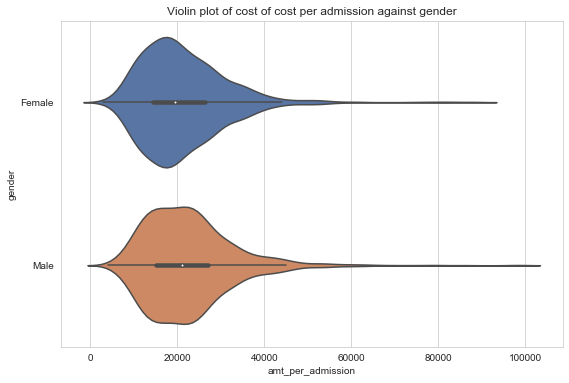

<Figure size 432x288 with 0 Axes>

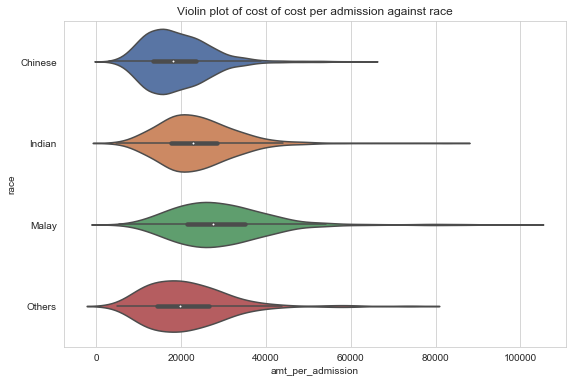

<Figure size 432x288 with 0 Axes>

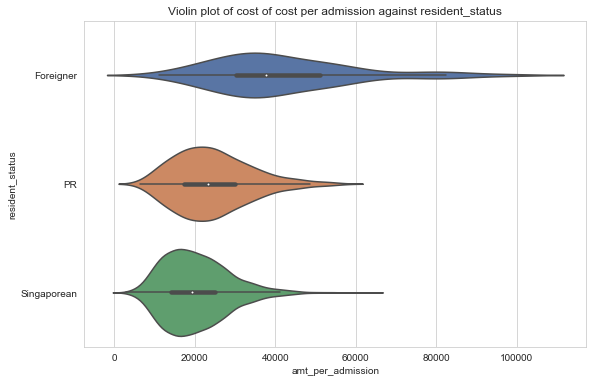

<Figure size 432x288 with 0 Axes>

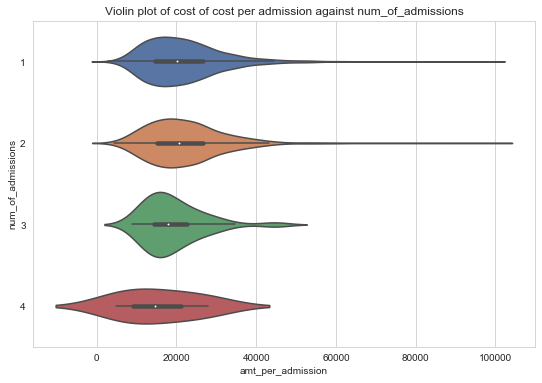

<Figure size 432x288 with 0 Axes>

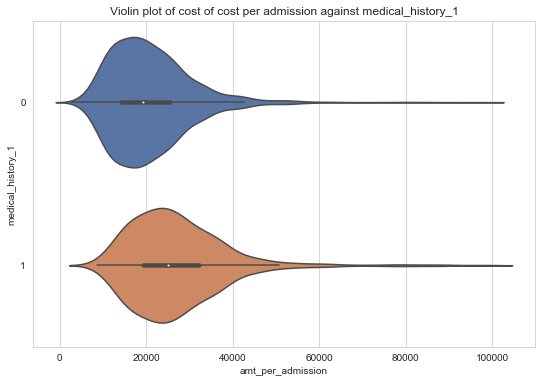

<Figure size 432x288 with 0 Axes>

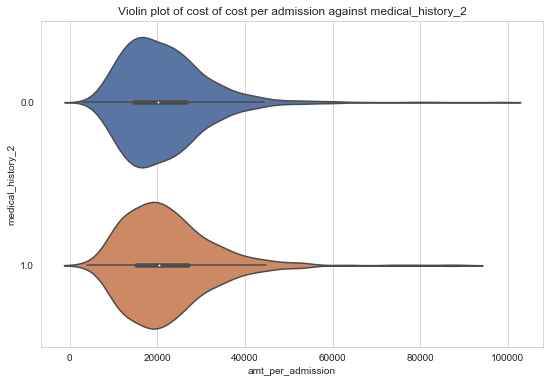

<Figure size 432x288 with 0 Axes>

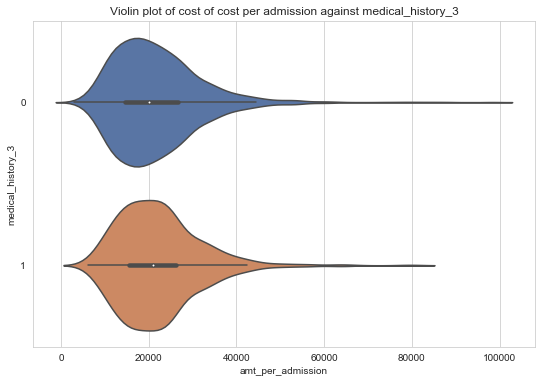

<Figure size 432x288 with 0 Axes>

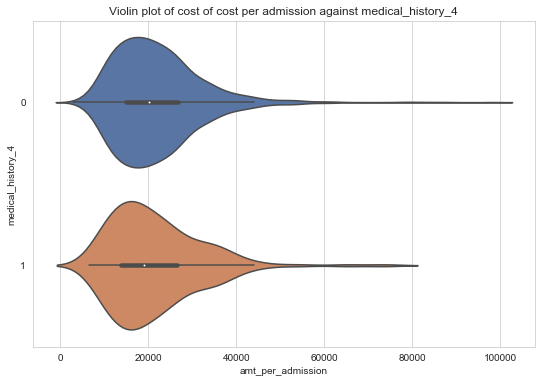

<Figure size 432x288 with 0 Axes>

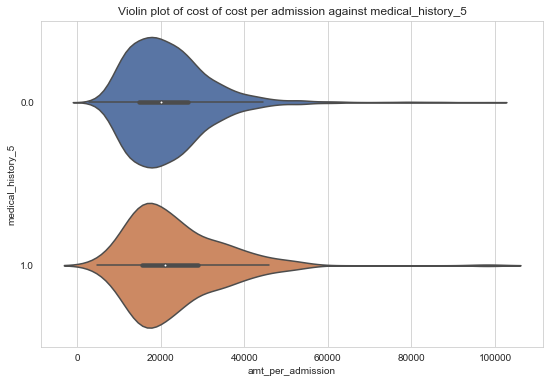

<Figure size 432x288 with 0 Axes>

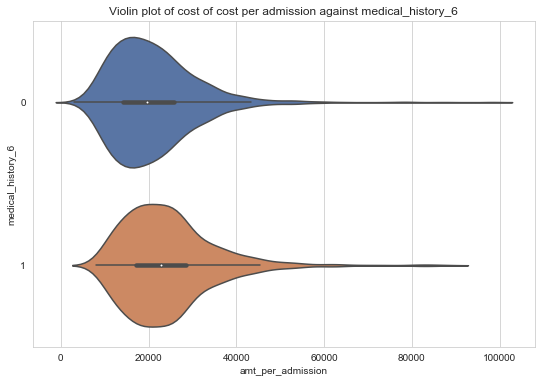

<Figure size 432x288 with 0 Axes>

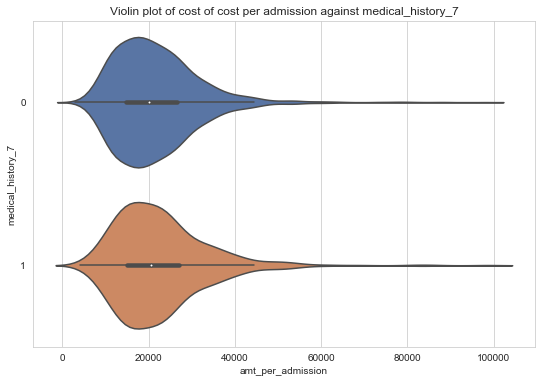

<Figure size 432x288 with 0 Axes>

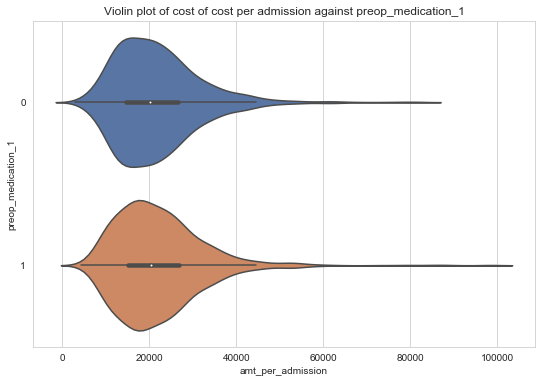

<Figure size 432x288 with 0 Axes>

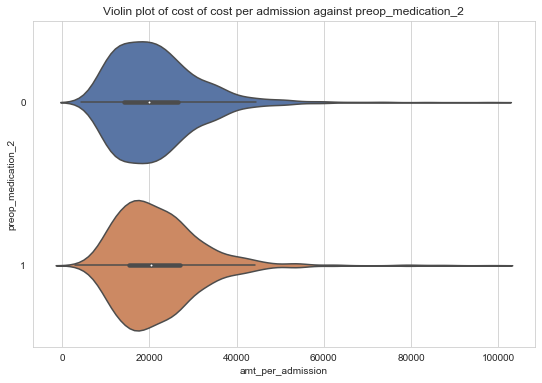

<Figure size 432x288 with 0 Axes>

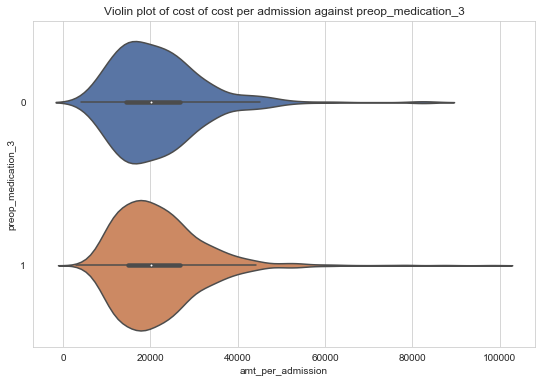

<Figure size 432x288 with 0 Axes>

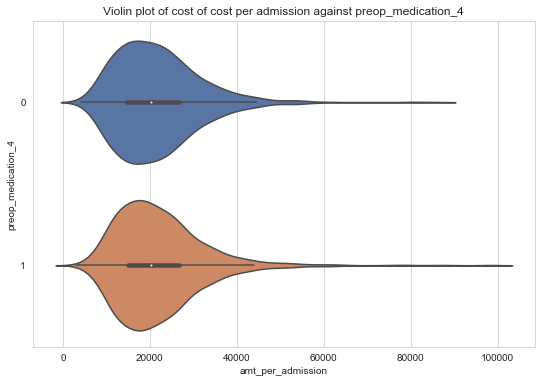

<Figure size 432x288 with 0 Axes>

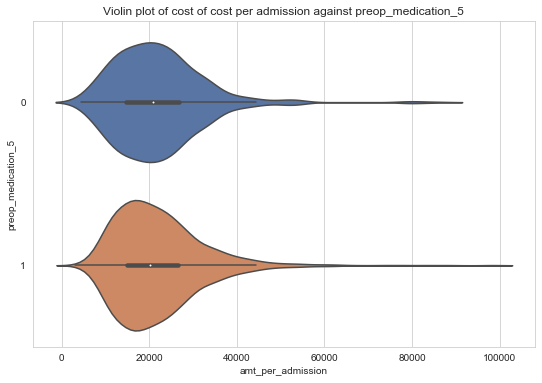

<Figure size 432x288 with 0 Axes>

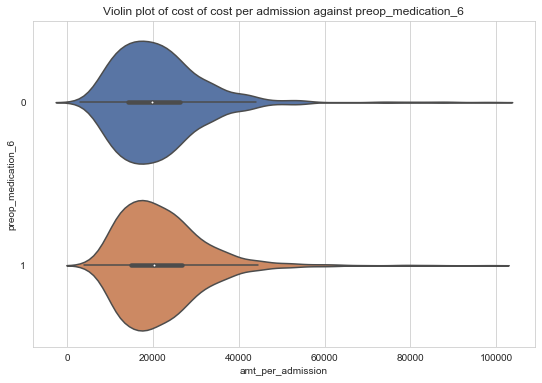

<Figure size 432x288 with 0 Axes>

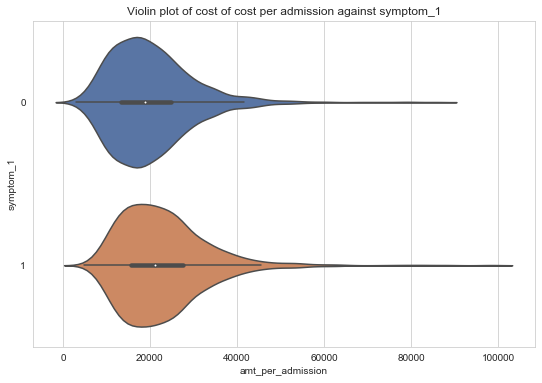

<Figure size 432x288 with 0 Axes>

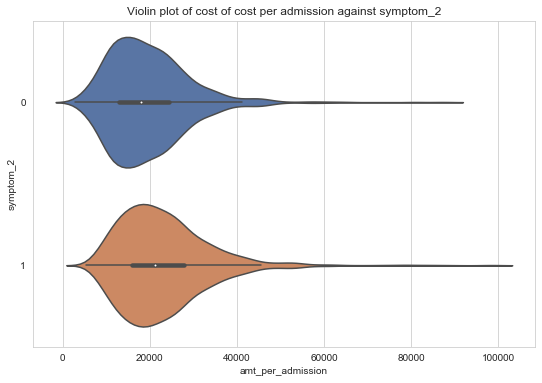

<Figure size 432x288 with 0 Axes>

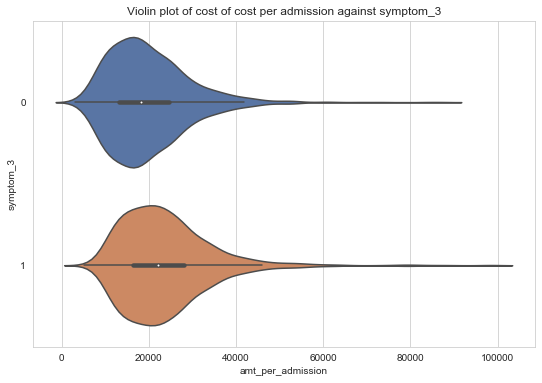

<Figure size 432x288 with 0 Axes>

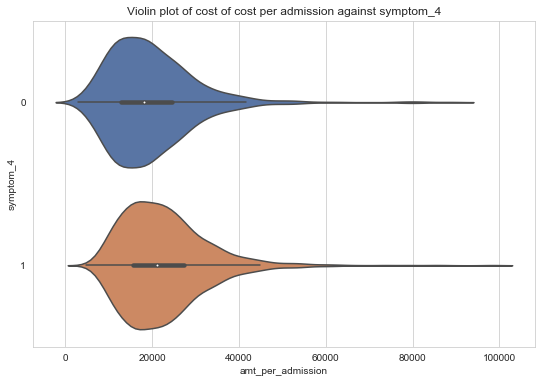

<Figure size 432x288 with 0 Axes>

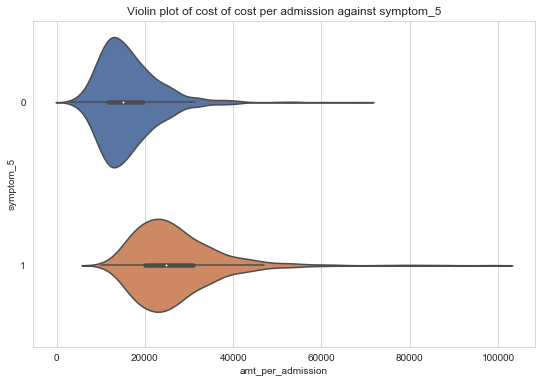

<Figure size 432x288 with 0 Axes>

In [30]:
"""Bivariate plots for categorical numerical variables"""
#for categorical variables
sns.set_palette('deep')
sns.set_style('whitegrid')
for col in cat_var.columns:
    plt.figure(figsize = (9,6))
    sns.violinplot(num_var.amt_per_admission, cat_var[col], inner = 'box')
    plt.title('Violin plot of cost of cost per admission against ' + col)
    plt.show()
    plt.clf()


Males seem have higher costs than females. For race, Chinese < Others < Malay < Indians in terms of costs.  Foreigners pay the most, while PR pays less, but still pays more than Singaporeans, which makes sense. 

Medical history 1 and 6 seems to have higher costs due to the higher median are having a larger distribution having higher costs. Number of admissions doesn't say anything useful. Pre-op medication doesn't indicate much. Having symptoms generally indicate slightly higher cost except symptom 5 which shows substantially increased cost.

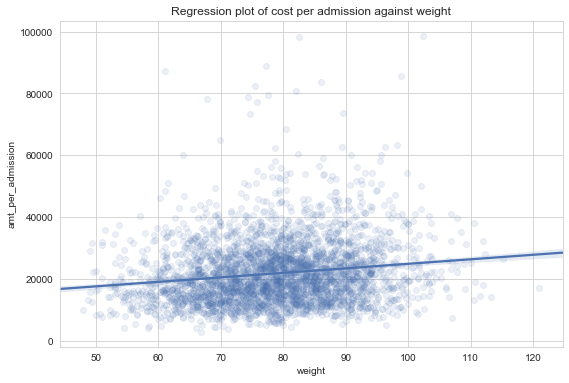

<Figure size 432x288 with 0 Axes>

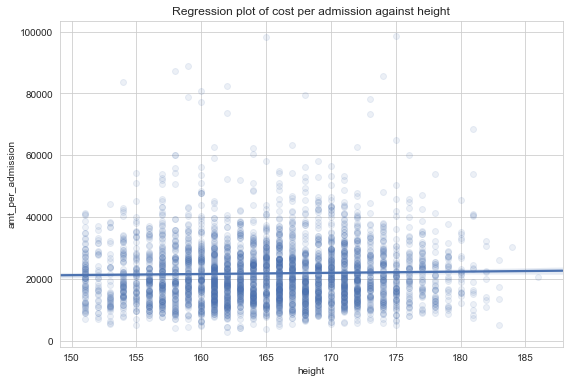

<Figure size 432x288 with 0 Axes>

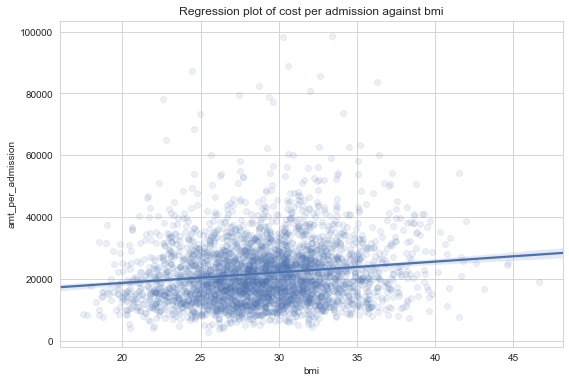

<Figure size 432x288 with 0 Axes>

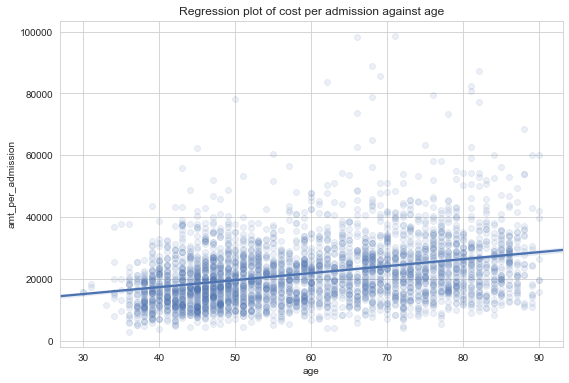

<Figure size 432x288 with 0 Axes>

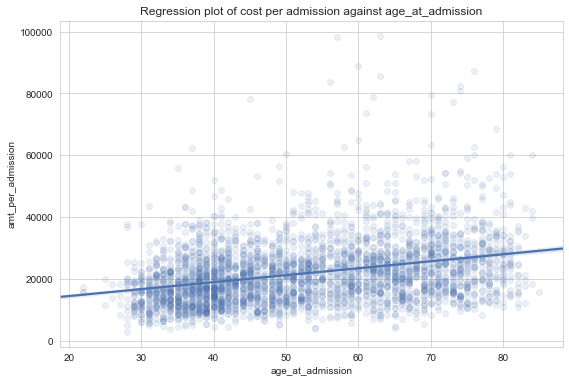

<Figure size 432x288 with 0 Axes>

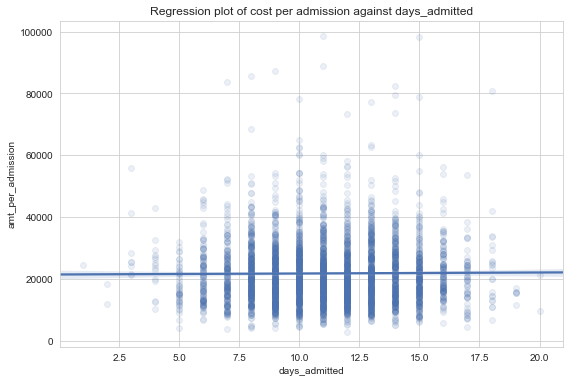

<Figure size 432x288 with 0 Axes>

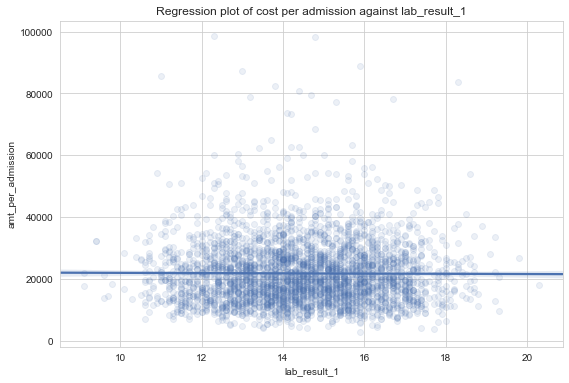

<Figure size 432x288 with 0 Axes>

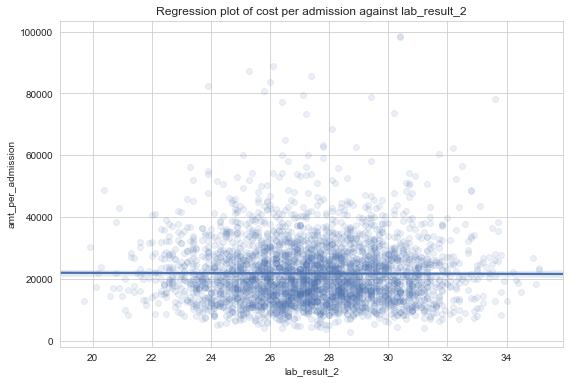

<Figure size 432x288 with 0 Axes>

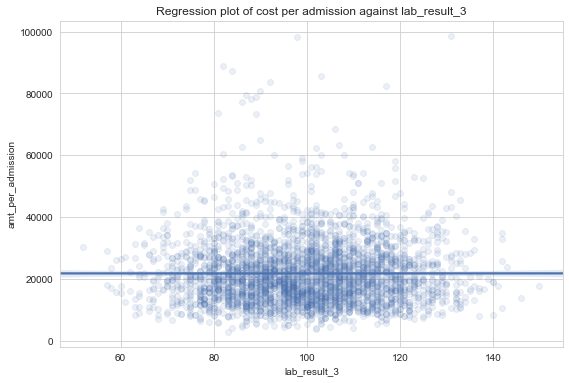

<Figure size 432x288 with 0 Axes>

In [31]:
"""Bivariate plots for numerical variables"""
for col in num_var.columns.drop('amt_per_admission'):
    plt.figure(figsize = (9,6))
    sns.regplot(num_var[col], num_var.amt_per_admission, scatter_kws={'alpha': 0.1})
    plt.title('Regression plot of cost per admission against ' + col)
    plt.show()
    plt.clf()

#BMI shows clearest trend of linear increase align with age. Interestingly, days_admitted does not contribute at all.
#All of the lab tests don't show anything. Weight shows more trend than height, so using bmi might dilute the effect of weight
#afterall

Age, age at admission and BMI shows clearest trend of linear increase. Weight shows steeper trendline than height, so using bmi might dilute the effect of weight afterall.

Interestingly, days_admitted does not contribute at all. All of the lab test results don't show anything. 

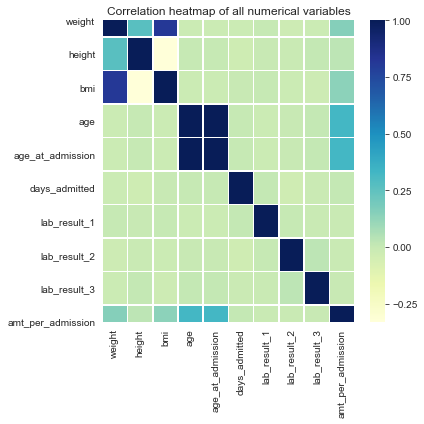

In [32]:
"""Correlation heatmap"""
plt.figure(figsize = (6,6))
sns.heatmap(num_var.corr(), xticklabels= True, linewidths=.5, cmap="YlGnBu")
plt.title('Correlation heatmap of all numerical variables')
plt.tight_layout()

Age admission correlates to age, as expected. Similar to BMI, height and weight. No correlation between other variables. Seems like linear models should do fine as long as correlated variables are removed.

## Proceed to Machine Learning

In [33]:
"""Import packges necessary for ML"""
import sklearn
from sklearn.metrics import make_scorer, mean_squared_log_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split, ParameterGrid, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import ElasticNet
import math

In [34]:
"""Get dummy variables"""
df_full.reset_index(inplace = True, drop = True) 
#Resetting index because they are still retained from previous steps
df_full.drop('patient_id', axis = 1, inplace = True) #Won't need this anymore
df_full.num_of_admissions = df_full.num_of_admissions.astype(np.int) #conversion to float because ordinal category
dummies = pd.get_dummies(df_full[['gender', 'race', 'resident_status']]) 
#These variables are nominal, so create dataframe for dummies
df_full = pd.concat([dummies, df_full.drop(['gender','race', 'resident_status'], axis = 1)], axis = 1)
#Then concat df_full to dummies, while removing the original variables which have been dummy-fied
df_full

,gender_Female,gender_Male,race_Chinese,race_Indian,race_Malay,race_Others,resident_status_Foreigner,resident_status_PR,resident_status_Singaporean,weight,...,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,amt_per_admission
0,1,0,0,1,0,0,0,0,1,68.1,...,1,1,1,0,0,1,14.2,27.0,81.0,19564.166266
1,1,0,1,0,0,0,0,0,1,76.5,...,1,1,1,1,1,1,14.3,27.2,92.0,20465.398960
2,0,1,1,0,0,0,0,0,1,69.7,...,0,0,0,1,1,1,14.4,26.6,92.0,14435.913476
3,0,1,1,0,0,0,0,0,1,66.7,...,1,1,0,0,1,0,18.0,26.6,92.0,6578.387441
4,0,1,0,0,1,0,0,0,1,96.9,...,1,1,1,1,1,1,14.9,26.7,97.0,45452.313094
5,0,1,1,0,0,0,0,0,1,91.6,...,1,1,1,1,1,1,14.1,27.3,98.0,22511.346126
6,1,0,1,0,0,0,0,1,0,65.0,...,0,1,1,1,0,0,11.2,30.0,103.0,13805.400576
7,0,1,0,0,1,0,0,0,1,90.1,...,1,1,1,0,1,0,14.4,27.3,107.0,17995.220652
8,0,1,0,0,1,0,0,0,1,88.1,...,1,1,1,1,1,0,15.2,26.6,115.0,22306.032631
9,1,0,1,0,0,0,0,0,1,68.7,...,1,0,0,0,1,1,12.7,30.5,102.0,12869.617976


In [35]:
"""Split into training set and test set"""
seed = 2604 #set seed so that the results are reproducible later on

X = df_full.iloc[:,:-1] #separating predictor variables and outcome variable
Y = df_full.iloc[:,-1]

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = seed, shuffle = True)
#No need validation set because will use K-Fold cross validation on training set later on to choose
#optimised model

In [36]:
"""Random Forest"""
#Here, I will find the best parameters for our current dataset first. 
#Also, take note no standardisation yet because RF does not require/perform better with standardisation
rf = RandomForestRegressor(random_state = seed)
rf_grid = {'max_features': ['auto'],
            'n_estimators': [700],
            'max_depth': [20],
            'min_samples_leaf': [1]
            }

#Creating root mean squared log error scorer
def rmsle(y_actual, y_predicted):
    rmsle = math.sqrt(mean_squared_log_error(y_actual, y_predicted))
    return rmsle

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

"""Setting K-Fold function to split the training set into training + validation sets (20%) when running RF later"""
kf = KFold(5, shuffle = True, random_state=0)

Note: Use RMSLE because RMSLE overpenalises underprediction. In my opinion, when it comes to heathcare costs, it is always good to overpredict. This scorer will be used for the rest of the models.

The full grid was not run at the same time, in consideration of time.

Grid used:

{'max_features': ['auto', 'log2', 'sqrt'],

 'n_estimators': [100,200,300,400, 500,700,900],
 
 'max_depth': [1,5,10,15,20],
 
 'min_samples_leaf': [1,5,10,15]
 
}

In [37]:
"""Grid search for best parameters for dataset"""
grid_search = GridSearchCV(rf, param_grid= rf_grid, scoring= rmsle_scorer, n_jobs = -1, cv = kf, refit = True)
grid_search.fit(x_train, y_train)
print("Best params:", grid_search.best_params_)
print("Best score =", -grid_search.best_score_)

#best params: max_depth = 20, min_samples_leaf = 1, n_estimators = 700

Best params: {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 700}
Best score = 0.1390632931794567


In [38]:
"""Using the best parameters for selection of variables. Will consider interpretability of model at this point 
in time. Selection also based on RMSLE score + OOB score"""
all_cols = df_full.columns[:-1] 

#Defining function to input predictor variables and automate outputs e.g. scores + plots
def rf_generator(predictor_cols): #Has to be a list
    global rf #make rf into a global function so that can call again later for testing
    rf = RandomForestRegressor(n_estimators= 700,max_depth=20, min_samples_leaf=1, n_jobs = -1,
                               random_state= seed, oob_score=True, verbose = 1)
    scores = -cross_val_score(rf, x_train[predictor_cols], y_train, scoring= rmsle_scorer, n_jobs = -1, cv = kf)
    #Identifying cross-validation scores using 5-fold KF
    print("scores of cross-validation =", np.round(scores,3)) #Cross-validation scores from 5-fold KF
    print("mean scores of cross-validation =", round(np.mean(scores), 3)) ##Finding mean of all cross-validation scores
    rf.fit(x_train[predictor_cols], y_train) #Fitting predictor variables to actual Random Forest class
    print("Out-of-bag score = ", round(rf.oob_score_,3)) #0.9. Oob score as a metric of being able to predict what's in unseen data

    #This is for creating feature importance plot
    importances = pd.DataFrame(rf.feature_importances_).T # to correct dataframe to right shape
    importances.columns = df_full[predictor_cols].columns #rf.estimators will pull every single tree
    global indices #call as global first so can see all the indices later on
    indices = importances.sort_values(by = 0, axis = 1, ascending= False) #sorts from largest to smallest
    indices

#Generating the feature importance plot
    sns.set_style('whitegrid')
    sns.set_palette(sns.color_palette("Blues_r"))
    plt.figure(figsize=(15,6))

    ax = sns.barplot(indices.columns, indices.iloc[0, :], palette = plt.cm.Blues(indices.iloc[0, :]*50))
    plt.title("Feature importances")
    plt.ylabel("Level of Importance")
    ax.set_xticklabels(rotation = 45, ha = 'right', labels = indices.columns)
    plt.tight_layout()
    plt.show()


scores of cross-validation = [0.145 0.129 0.132 0.147 0.142]
mean scores of cross-validation = 0.139


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    6.4s finished


Out-of-bag score =  0.898


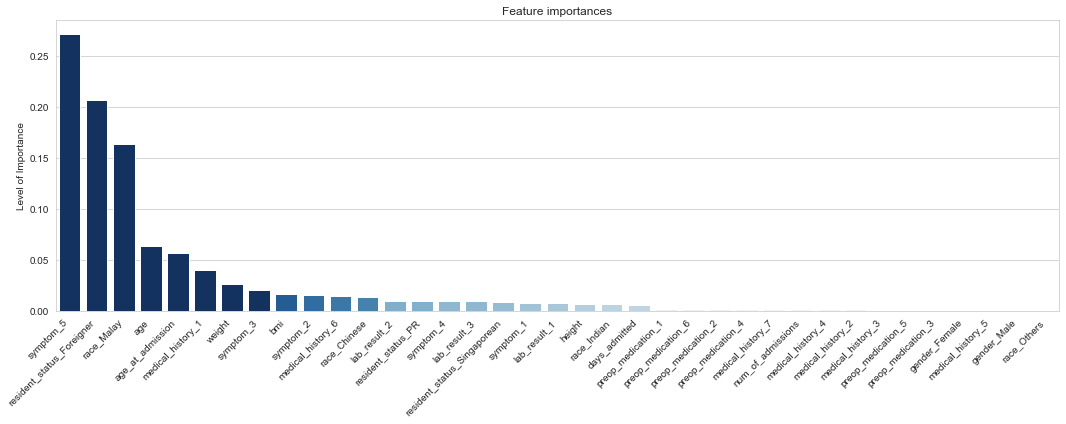

In [39]:
rf_generator(all_cols)
#Here, it can be seen that symptom 5, being a foreigner, race_Malay are the top most contributers to the model. 
#None of the pre-ops medication appeared to be significant. Same with gender. Will remove all variables which 
#did not seem to be important (i.e. very close to 0) to see how it affects RMSLE score + OOB score.

So now that I know my function works beautifully, the below are actually the optimisation steps that I have taken to arrive at the best set of variables. 

__I have converted the whole chunk of code into a Markdown__ just in case you wanted to just see the most important variables which can predict for total costs using Random Forest. The most important variables will be in the cell after.

Scores/metrics obtained from using the actual RF algorithm gave the same results as when I ran on PyCharm.

## Convert back to code cell to see the optimisation process
print([x for x in indices]) #indices is a global variable in the function for generation random forests. Stores
#all of the feature importances + respective columns

print("\n")

cols_first = ['symptom_5', 'resident_status_Foreigner', 'race_Malay', 'age', 'age_at_admission', 'medical_history_1',
                  'weight', 'symptom_3', 'bmi', 'symptom_2', 'medical_history_6', 'race_Chinese', 'lab_result_2',
                  'resident_status_PR', 'symptom_4', 'lab_result_3', 'resident_status_Singaporean', 'symptom_1',
                  'lab_result_1', 'height', 'race_Indian', 'days_admitted']
rf_generator(cols_first)
#Improved OOB score to 0.902 and RMSLE to 0.137

#Try to remove those overlapping variables e.g. weight, height, bmi??
without_height_and_weight = ['symptom_5', 'resident_status_Foreigner', 'race_Malay', 'age', 'age_at_admission', 'medical_history_1',
                  'symptom_3', 'bmi', 'symptom_2', 'medical_history_6', 'race_Chinese', 'lab_result_2',
                  'resident_status_PR', 'symptom_4', 'lab_result_3', 'resident_status_Singaporean', 'symptom_1',
                  'lab_result_1', 'race_Indian', 'days_admitted']
rf_generator(without_height_and_weight)
#It does better!! How about just including weight instead of bmi? because weight had higher importance than bmi

without_height_and_bmi = ['symptom_5', 'resident_status_Foreigner', 'race_Malay', 'age', 'age_at_admission', 'medical_history_1',
                  'symptom_3', 'weight', 'symptom_2', 'medical_history_6', 'race_Chinese', 'lab_result_2',
                  'resident_status_PR', 'symptom_4', 'lab_result_3', 'resident_status_Singaporean', 'symptom_1',
                  'lab_result_1', 'race_Indian', 'days_admitted']
rf_generator(without_height_and_bmi)

#Removing either age or age at admission
without_age = ['symptom_5', 'resident_status_Foreigner', 'race_Malay', 'age_at_admission', 'medical_history_1',
                  'symptom_3', 'weight', 'symptom_2', 'medical_history_6', 'race_Chinese', 'lab_result_2',
                  'resident_status_PR', 'symptom_4', 'lab_result_3', 'resident_status_Singaporean', 'symptom_1',
                  'lab_result_1', 'race_Indian', 'days_admitted']
rf_generator(without_age)

without_age_at_admission = ['symptom_5', 'resident_status_Foreigner', 'race_Malay', 'age', 'medical_history_1',
                  'symptom_3', 'weight', 'symptom_2', 'medical_history_6', 'race_Chinese', 'lab_result_2',
                  'resident_status_PR', 'symptom_4', 'lab_result_3', 'resident_status_Singaporean', 'symptom_1',
                  'lab_result_1', 'race_Indian', 'days_admitted']
rf_generator(without_age_at_admission)
#age at admission gave better scores

#days admitted (bc it was engineered). Also, given that there are multiple rows of the same participant,
remove_days_admitted = ['symptom_5', 'resident_status_Foreigner', 'race_Malay', 'age_at_admission', 'medical_history_1',
                  'symptom_3', 'weight', 'symptom_2', 'medical_history_6', 'race_Chinese', 'lab_result_2',
                  'resident_status_PR', 'symptom_4', 'lab_result_3', 'resident_status_Singaporean', 'symptom_1',
                  'lab_result_1', 'race_Indian']
rf_generator(remove_days_admitted)

#Remove Resident status PR and Singaporean to implicitly indicate foreigner
pr_sg_removed = ['symptom_5', 'resident_status_Foreigner', 'race_Malay', 'age_at_admission', 'medical_history_1',
                  'symptom_3', 'weight', 'symptom_2', 'medical_history_6', 'race_Chinese', 'lab_result_2',
                  'symptom_4', 'lab_result_3','symptom_1',
                  'lab_result_1', 'race_Indian']
rf_generator(pr_sg_removed)
#Poor score, add both variables back in

#Removing last 2: race_indian and lab_result_1
remove_last_2 = ['symptom_5', 'resident_status_Foreigner', 'race_Malay', 'age_at_admission', 'medical_history_1',
                  'symptom_3', 'weight', 'symptom_2', 'medical_history_6', 'race_Chinese', 'lab_result_2',
                  'resident_status_PR', 'symptom_4', 'lab_result_3', 'resident_status_Singaporean', 'symptom_1']
rf_generator(remove_last_2)

#Removing last 2: 'resident_status_Singaporean' & 'symptom_1'
remove_last_2 = ['symptom_5', 'resident_status_Foreigner', 'race_Malay', 'age_at_admission', 'medical_history_1',
                  'symptom_3', 'weight', 'symptom_2', 'medical_history_6', 'race_Chinese', 'lab_result_2',
                  'resident_status_PR', 'symptom_4', 'lab_result_3']
rf_generator(remove_last_2)
#Score drops

remove_symptom_1 = ['symptom_5', 'resident_status_Foreigner', 'race_Malay', 'age_at_admission', 'medical_history_1',
                  'symptom_3', 'weight', 'symptom_2', 'medical_history_6', 'race_Chinese', 'lab_result_2',
                  'resident_status_PR', 'symptom_4', 'lab_result_3', 'resident_status_Singaporean']
rf_generator(remove_symptom_1)
#Score drops a lot

remove_singaporean = ['symptom_5', 'resident_status_Foreigner', 'race_Malay', 'age_at_admission', 'medical_history_1',
                  'symptom_3', 'weight', 'symptom_2', 'medical_history_6', 'race_Chinese', 'lab_result_2',
                  'resident_status_PR', 'symptom_4', 'lab_result_3', 'symptom_1']
rf_generator(remove_last_2)
#Similar to including both 'resident_status_Singaporean' & 'symptom_1'. Use the one with singaporean bc it can help with
#interpretability

scores of cross-validation = [0.133 0.118 0.116 0.134 0.13 ]
mean scores of cross-validation = 0.126


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    3.8s finished


Out-of-bag score =  0.915


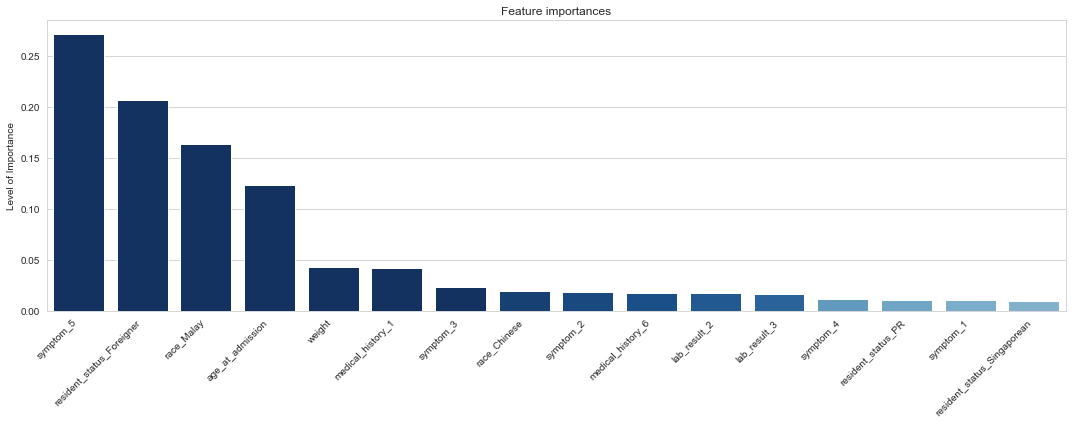

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:    0.2s finished


rmsle of prediction using test set =  0.117


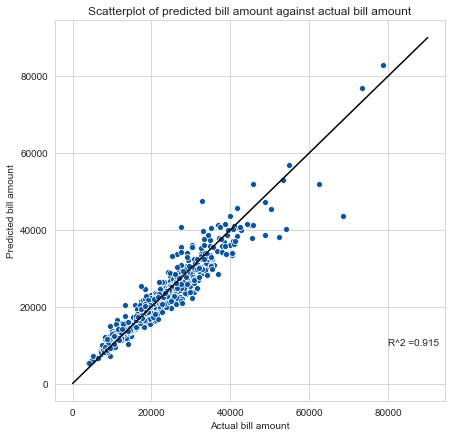

In [41]:
#Test trained model with best set of variables on test set. The name of the 
best_cols = ['symptom_5', 'resident_status_Foreigner', 'race_Malay', 'age_at_admission', 'medical_history_1',
                  'symptom_3', 'weight', 'symptom_2', 'medical_history_6', 'race_Chinese', 'lab_result_2',
                  'resident_status_PR', 'symptom_4', 'lab_result_3', 'resident_status_Singaporean', 'symptom_1']
rf_generator(best_cols)

predict = rf.predict(x_test[best_cols])

print("rmsle of prediction using test set = ",round(rmsle(y_test, predict), 3))
#Because the test set gave a rmsle which is substantially lower than training set (0.126), there is still room for
#optimisation. Some data is not being used, which could help the model training improve. 

plt.figure(figsize=(7,7))
sns.set_style("whitegrid")
sns.scatterplot(y_test, predict)
plt.plot(range(0,90000),range(0,90000), "k-") #This generates the diagonal line across the plot
plt.title("Scatterplot of predicted bill amount against actual bill amount")
plt.xlabel("Actual bill amount")
plt.ylabel("Predicted bill amount")
plt.annotate("R^2 =" + str(np.round(np.square((np.corrcoef(y_test, predict)[0][1])),3)), xy= (80000,10000))
plt.show()

Impurity-based feature importance can inflate the importance of numerical features. Seems like it is not the case in our dataset though so it should be fine because the most important variables were all categorical. 

The scatterplot above shows how the predicted bill amount just based on these few variables are enough to give a decent R2 score.

Given that the model was not overfit (because the test set rmsle was __lower__ than the training set rmsle), it indicates that there is still space to experiment with new features.

## Feature engineering part 2

In [42]:
"""Identifying total number of medical history per patient"""
df_full["num_of_diseases"] = df_full[['medical_history_1', 'medical_history_2', 'medical_history_3', 
                                      'medical_history_4', 'medical_history_5', 'medical_history_6',
                                      'medical_history_7']].astype(np.number).sum(axis = 1) 
print("Max number of medical history =", df_full.num_of_diseases.max(), ";", "Min number of medical history =", df_full.num_of_diseases.min())


"""Identifying total number of pre-operation medication per patient"""
df_full["num_of_preop_med"] = df_full[['preop_medication_1', 'preop_medication_2', 'preop_medication_3',
                                       'preop_medication_4', 'preop_medication_5',
                                       'preop_medication_6']].astype(np.number).sum(axis = 1)
print("Max number of preop meds =", df_full.num_of_preop_med.max(), ";", "Min number of preop meds =", df_full.num_of_preop_med.min())

"""Identifying total number of symptoms per patient"""
df_full["num_of_symptoms"] = df_full[['symptom_1', 'symptom_2', 'symptom_3', 'symptom_4', 'symptom_5']].astype(np.number).sum(axis = 1)
print("Max number of symptoms =", df_full.num_of_symptoms.max(), ";", "Min number of symptoms =", df_full.num_of_symptoms.min())

print(df_full.columns)

#Reorganising the dataset
df_full = df_full[['gender_Female', 'gender_Male', 'race_Chinese', 'race_Indian',
       'race_Malay', 'race_Others', 'resident_status_Foreigner',
       'resident_status_PR', 'resident_status_Singaporean', 'weight', 'height',
       'bmi', 'age', 'age_at_admission', 'num_of_admissions', 'days_admitted',
       'medical_history_1', 'medical_history_2', 'medical_history_3',
       'medical_history_4', 'medical_history_5', 'medical_history_6',
       'medical_history_7', 'preop_medication_1', 'preop_medication_2',
       'preop_medication_3', 'preop_medication_4', 'preop_medication_5',
       'preop_medication_6', 'symptom_1', 'symptom_2', 'symptom_3',
       'symptom_4', 'symptom_5', 'lab_result_1', 'lab_result_2',
       'lab_result_3', 'num_of_diseases', 'num_of_preop_med', 'num_of_symptoms', 'amt_per_admission']]


Max number of medical history = 5.0 ; Min number of medical history = 0.0
Max number of preop meds = 6.0 ; Min number of preop meds = 0.0
Max number of symptoms = 5.0 ; Min number of symptoms = 0.0
Index(['gender_Female', 'gender_Male', 'race_Chinese', 'race_Indian',
       'race_Malay', 'race_Others', 'resident_status_Foreigner',
       'resident_status_PR', 'resident_status_Singaporean', 'weight', 'height',
       'bmi', 'age', 'age_at_admission', 'num_of_admissions', 'days_admitted',
       'medical_history_1', 'medical_history_2', 'medical_history_3',
       'medical_history_4', 'medical_history_5', 'medical_history_6',
       'medical_history_7', 'preop_medication_1', 'preop_medication_2',
       'preop_medication_3', 'preop_medication_4', 'preop_medication_5',
       'preop_medication_6', 'symptom_1', 'symptom_2', 'symptom_3',
       'symptom_4', 'symptom_5', 'lab_result_1', 'lab_result_2',
       'lab_result_3', 'amt_per_admission', 'num_of_diseases',
       'num_of_preop_med', 

In [43]:
"""Splitting into training and test set"""
X = df_full.iloc[:,:-1] #separating predictor variables and outcome variable
Y = df_full.iloc[:,-1]

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = seed, shuffle = True)

## As above, I will convert the bottom code into a Markdown because it is just feature selection. The best set of variables will be fed into the algorithm in the cell after.

#Testing out importance of new variables by adding them to best rf model so far
with_new_var = ['symptom_5', 'resident_status_Foreigner', 'race_Malay', 'age_at_admission', 'medical_history_1',
            'symptom_3', 'weight', 'symptom_2', 'medical_history_6', 'race_Chinese', 'lab_result_2',
            'resident_status_PR', 'symptom_4', 'lab_result_3', 'resident_status_Singaporean', 'symptom_1',
             'num_of_diseases', 'num_of_preop_med', 'num_of_symptoms']
rf_generator(with_new_var)
#Vastly improved scores of oob score = 0.931 and mean rmsle = 0.104. All symptoms (except 5) lost its importance. 

remove_symptoms = ['symptom_5', 'resident_status_Foreigner', 'race_Malay', 'age_at_admission', 'medical_history_1',
             'weight',  'medical_history_6', 'race_Chinese', 'lab_result_2',
            'resident_status_PR', 'lab_result_3', 'resident_status_Singaporean',
             'num_of_diseases', 'num_of_preop_med', 'num_of_symptoms']
rf_generator(remove_symptoms)
#Same scores. Keep model because smaller.

"""From here on just removing the bottom few variables to see if it improves the score or not"""
remove_total_pre_ops = ['symptom_5', 'resident_status_Foreigner', 'race_Malay', 'age_at_admission', 'medical_history_1',
             'weight',  'medical_history_6', 'race_Chinese', 'lab_result_2',
            'resident_status_PR', 'lab_result_3', 'resident_status_Singaporean',
             'num_of_diseases', 'num_of_symptoms']
rf_generator(remove_total_pre_ops)
#Scores improved. RMSLE = 0.103; OOB score = 0.933

remove_singaporean = ['symptom_5', 'resident_status_Foreigner', 'race_Malay', 'age_at_admission', 'medical_history_1',
             'weight',  'medical_history_6', 'race_Chinese', 'lab_result_2',
            'resident_status_PR', 'lab_result_3', 'num_of_diseases', 'num_of_symptoms']
rf_generator(remove_singaporean)
#Scores improved. RMSLE = 0.104; OOB score = 0.933. Doesn't drop score by much, so remove

remove_lab_result_3 = ['symptom_5', 'resident_status_Foreigner', 'race_Malay', 'age_at_admission', 'medical_history_1',
             'weight',  'medical_history_6', 'race_Chinese', 'lab_result_2',
            'resident_status_PR', 'num_of_diseases', 'num_of_symptoms']
rf_generator(remove_lab_result_3)
#Scores improved. RMSLE = 0.101; OOB score = 0.937

remove_pr = ['symptom_5', 'resident_status_Foreigner', 'race_Malay', 'age_at_admission', 'medical_history_1',
             'weight',  'medical_history_6', 'race_Chinese', 'lab_result_2', 'num_of_diseases', 'num_of_symptoms']
rf_generator(remove_pr)
#Stop here because score dropped substantially after removing PR status. RMSLE = 0.119; OOB score = 0.917

scores of cross-validation = [0.099 0.096 0.1   0.102 0.107]
mean scores of cross-validation = 0.101


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    2.9s finished


Out-of-bag score =  0.937


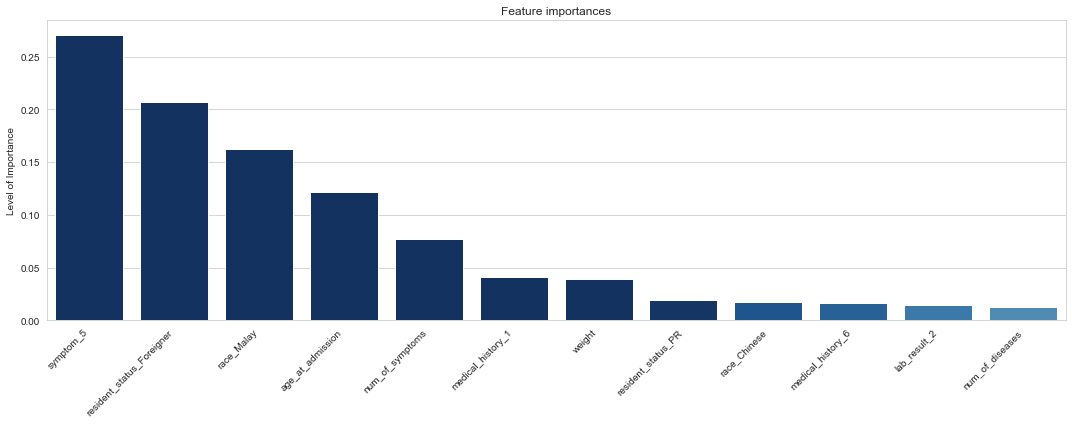

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:    0.1s finished


rmsle of prediction using test set =  0.092
The correlation coef of predicted and actual outcome = 0.968


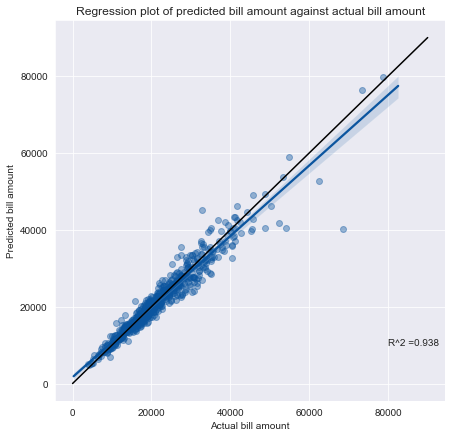

In [45]:
"""Test on test set"""
best_cols = ['symptom_5', 'resident_status_Foreigner', 'race_Malay', 'age_at_admission', 'medical_history_1',
             'weight',  'medical_history_6', 'race_Chinese', 'lab_result_2',
            'resident_status_PR', 'num_of_diseases', 'num_of_symptoms'] #Variables from removed_singaporean iteration
rf_generator(best_cols)

predict = rf.predict(x_test[best_cols])

print("rmsle of prediction using test set = ",round(rmsle(y_test, predict), 3)) #0.092
    #Test set still gave rmsle which is much lower than there is still room for
    #optimisation. Some data is not being used, which could help the model training improve


sns.set_style("darkgrid")
plt.figure(figsize = (7,7))
sns.regplot(y_test, predict, scatter_kws={'alpha': 0.4})
plt.plot(range(0,90000),range(0,90000), "k-")
plt.annotate("R^2 =" + str(np.round(np.square((np.corrcoef(y_test, predict)[0][1])),3)), xy= (80000,10000))
plt.title("Regression plot of predicted bill amount against actual bill amount")
plt.xlabel("Actual bill amount")
plt.ylabel("Predicted bill amount")

print("The correlation coef of predicted and actual outcome =", np.round(np.corrcoef(y_test, predict)[0][1],3)) #corrcoef = 0.968


### Interpretation of the Random Forest runs so far
The above shows how random forest is actually a pretty decent algorithm in predicting cost of care based on the various demographics and clinical data.

Of all the variables, 12 variables were selected and useful to predicting cost of care. Symptom 5 has the most importance, followed by being a Foreigner and Malay. Being of a Chinese rate is also important in driving cost, but not as much as being Malay. Indians and Others are not important. Perhaps it could be a disease which tends to appear in Malays, followed by the Chinese. Being a PR is also relatively informative. Age at admission was found to be more important than age as of 2020. 

Weight was found to be more important than height and BMI.  Medical history 1 and 6 are important. Lab results 2 is substantial. Lastly, the only generated variables which were important was found to be number of diseases and symptoms, although they are at the end of the list. 

Now that I am done with Random Forest, I will now proceed on to Elastic Net regression to see if any further optimisation is possible. 

## Feature engineering part 3 + Elastic Net

In [46]:
"""Elastic Net Regression: To see if linear model works. Also, using the best set of variables, 
engineer diff variants of continuous variables + standardising the x-test and y-test"""

best_df = df_full[['symptom_5', 'resident_status_Foreigner', 'race_Malay', 'age_at_admission', 'medical_history_1',
             'weight',  'medical_history_6', 'race_Chinese', 'lab_result_2',
            'resident_status_PR', 'num_of_diseases', 'num_of_symptoms', 'amt_per_admission']]

In [47]:
"""defining standardiser so it's easier to standardise variables later"""
def standardiser(col):
    global std_col
    std_col = (col-col.mean())/col.std()
    return(std_col)

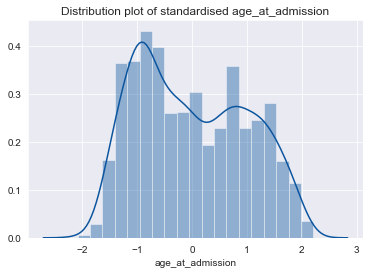

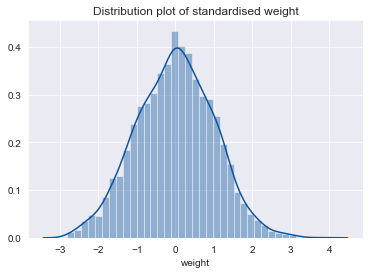

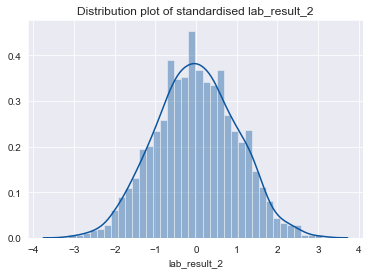

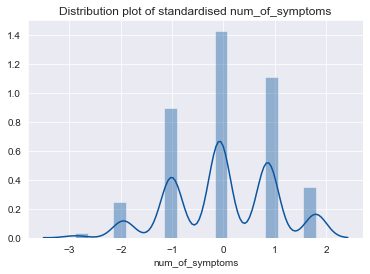

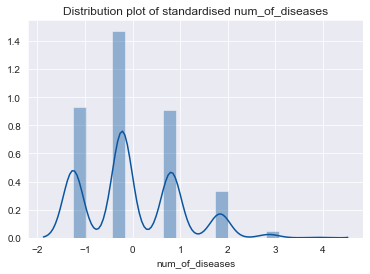

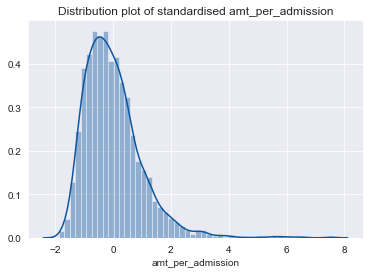

In [48]:
"""This part is just to observe how the distribution of variables improves through applying certain tranformations.
"""
#Looking at distribution of certain manipulated variables
sns.distplot(standardiser(best_df.age_at_admission)) #not normal-like
plt.title("Distribution plot of standardised age_at_admission")
plt.show()

sns.distplot(standardiser(best_df.weight))
plt.title("Distribution plot of standardised weight")
plt.show()
sns.distplot(standardiser(best_df.lab_result_2))
plt.title("Distribution plot of standardised lab_result_2")
plt.show()
sns.distplot(standardiser(best_df.num_of_symptoms))
plt.title("Distribution plot of standardised num_of_symptoms")
plt.show()
sns.distplot(standardiser(best_df.num_of_diseases)) #not normal-like
plt.title("Distribution plot of standardised num_of_diseases")
plt.show()
sns.distplot(standardiser(best_df.amt_per_admission)) #not normal-like
plt.title("Distribution plot of standardised amt_per_admission")
plt.show()

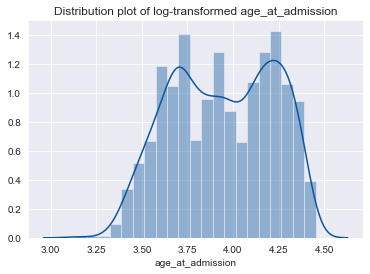

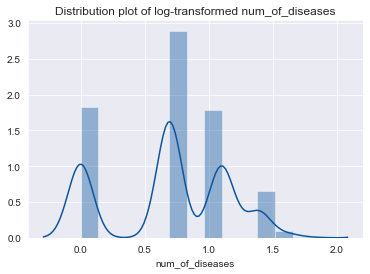

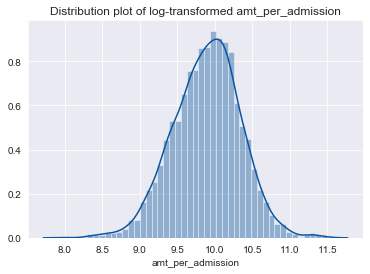

In [49]:
#Trying log transformation to the non-normal looking variables after standardisation
sns.distplot(np.log1p(best_df.age_at_admission)) #more normal. Still have slight skew
plt.title("Distribution plot of log-transformed age_at_admission")
plt.show()

sns.distplot(np.log1p(best_df.num_of_diseases)) #not normal-like
plt.title("Distribution plot of log-transformed num_of_diseases")
plt.show()

sns.distplot(np.log1p(best_df.amt_per_admission)) #better
plt.title("Distribution plot of log-transformed amt_per_admission")
plt.show()

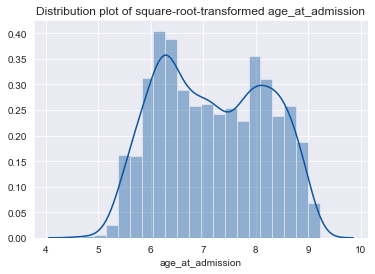

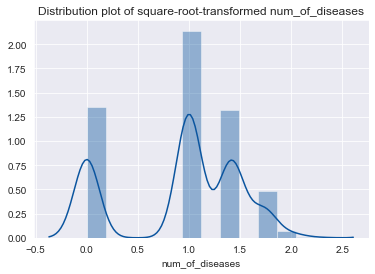

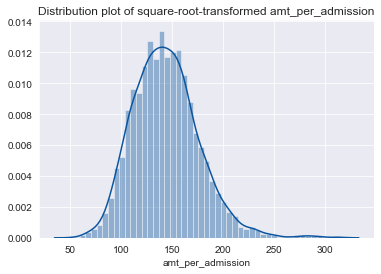

In [50]:
#Trying square root transformation to the non-normal looking variables after log transformation
sns.distplot(np.sqrt(best_df.age_at_admission)) #more normal. No skew
plt.title("Distribution plot of square-root-transformed age_at_admission")
plt.show()

sns.distplot(np.sqrt(best_df.num_of_diseases)) #not normal-like
plt.title("Distribution plot of square-root-transformed num_of_diseases")
plt.show()

sns.distplot(np.sqrt(best_df.amt_per_admission)) #not so good. stick with log transform
plt.title("Distribution plot of square-root-transformed amt_per_admission")
plt.show()

In [51]:
"""Did not transform number of diseases and number of symptoms
Square-root transformed age, log transform total cost
Standardise weight and lab result 2 AFTER splitting test and training set"""

best_df["sqrt_age"] = np.sqrt(best_df.age_at_admission)
best_df["log_amt"] = np.log(best_df.amt_per_admission)
best_df = best_df[['symptom_5', 'resident_status_Foreigner', 'race_Malay',
       'age_at_admission', 'medical_history_1', 'weight', 'medical_history_6',
       'race_Chinese', 'lab_result_2', 'resident_status_PR', 'num_of_diseases',
       'num_of_symptoms', 'sqrt_age', 'log_amt']]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [52]:
"""Split into training set and test set + Standardisation of weight and lab_results_2"""
seed = 2604

X = best_df.iloc[:,:-1] #separating predictor variables and outcome variable
Y = best_df.iloc[:,-1]

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = seed, shuffle = True)
#Standardising weight and lab results 2
x_train["std_weight"] = standardiser(x_train.weight)
x_test["std_weight"] = standardiser(x_test.weight)
x_train["std_lab_result_2"] = standardiser(x_train.lab_result_2)
x_test["std_lab_result_2"] = standardiser(x_test.lab_result_2)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy o

Train score =  {'alpha': 0.0005, 'l1_ratio': 0.1}
RMSLE of Elastic Net = 0.00856


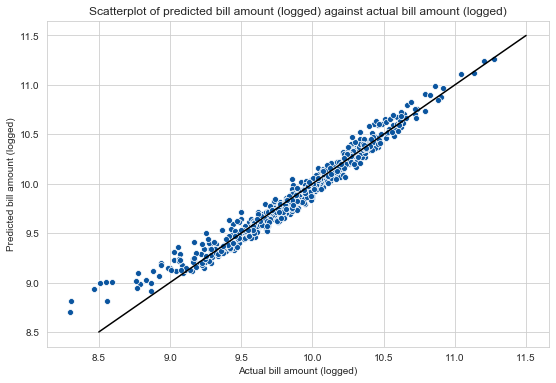

In [58]:
"""Optimisation of elastic net"""
elastic_grid = [{'alpha': [0.0005, 0.1, 0.5, 0.9, 0.95, 0.99, 1],
          'l1_ratio': np.arange(0,1+0.1,0.1)}]

elastic_reg = ElasticNet(random_state=seed, tol = 0.15) #Have to increase tolerance otherwise cannot converge

#Elastic Net function to test out the different parameters
x_train.columns
predictor_cols = ['symptom_5', 'resident_status_Foreigner', 'race_Malay',
       'age_at_admission', 'medical_history_1', 'weight', 'medical_history_6',
       'race_Chinese', 'lab_result_2', 'resident_status_PR', 'num_of_diseases',
       'num_of_symptoms', 'sqrt_age', 'std_weight', 'std_lab_result_2']


"""Creation of elastic net function similar to random forest"""
def cv_elastic_net(predictor_cols):
    grid_search = GridSearchCV(elastic_reg, param_grid= elastic_grid, scoring= rmsle_scorer, n_jobs = -1, cv = kf,
                               refit = True)
    grid_search.fit(x_train[predictor_cols], y_train)
    print("Train score = ",grid_search.best_params_) #alpha = 0.0005, l1 ratio = 0.1. Hence, favouring ridge regression
    predict = grid_search.predict(x_test[predictor_cols])

    print("RMSLE of Elastic Net =", np.round(rmsle(y_test,predict),5))
    

    sns.set_style("whitegrid")
    plt.figure(figsize = (9,6))
    sns.scatterplot(y_test, predict)
    plt.plot((8.5,11.5),(8.5,11.5), "k-")
    plt.title("Scatterplot of predicted bill amount (logged) against actual bill amount (logged)")
    plt.xlabel("Actual bill amount (logged)")
    plt.ylabel("Predicted bill amount (logged)")

#No error only when outcome is logged. Will have negative values if there's no log

cv_elastic_net(predictor_cols)  #testing function. Best params found to be alpha: 0.0005 and l1_ratio = 0.0 i.e. 
#Ridge regression

Train score =  {'alpha': 0.0005, 'l1_ratio': 0.0}
RMSLE of Elastic Net = 0.00856


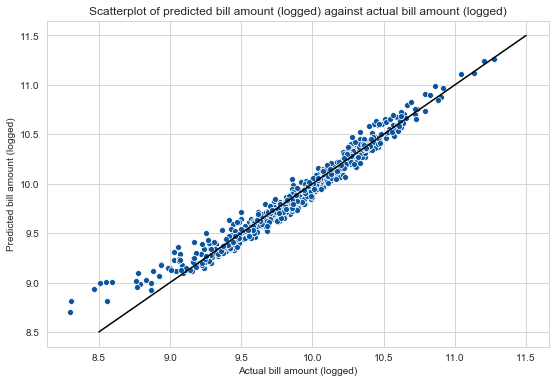

In [59]:
"""Elastic ridge regression using original variables"""
vanilla = ['symptom_5', 'resident_status_Foreigner', 'race_Malay',
       'age_at_admission', 'medical_history_1', 'weight', 'medical_history_6',
       'race_Chinese', 'lab_result_2', 'resident_status_PR', 'num_of_diseases',
       'num_of_symptoms']
cv_elastic_net(vanilla) #RMSLE of 0.00856. Best params still found to be alpha: 0.0005 and l1_ratio = 0.0

Results look good, but then it looks fishy because the fit looks a bit too good. I sense overfitting.

scores of cross-validation = [0.008 0.007 0.007 0.008 0.008]
mean scores of cross-validation = 0.00768
rmsle of training = 0.00762
rmsle of test = 0.00856


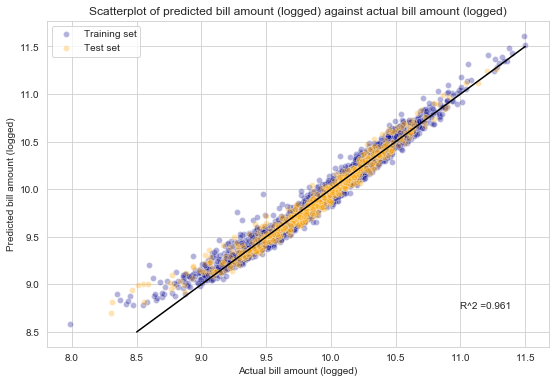

In [71]:
"""Defining the elastic_net function to collect training and test scores"""
def elastic_generator(predictor_cols): #Has to be a list
    global elastic #make elastic into a global function so that can call again later for testing
    elastic = ElasticNet(alpha = 0.0005, l1_ratio = 0.05, random_state=seed, tol = 0.15)
    scores = -cross_val_score(elastic, x_train[predictor_cols], y_train, scoring= rmsle_scorer, n_jobs = -1, cv = kf)
    print("scores of cross-validation =", np.round(scores,3))
    print("mean scores of cross-validation =", round(np.mean(scores), 5))
    elastic.fit(x_train[predictor_cols], y_train)
    train_pred = elastic.predict(x_train[predictor_cols]) #training predictions
    print("rmsle of training =",np.round(rmsle(y_train, train_pred),5)) #training prediction rmsle
    test_pred = elastic.predict(x_test[predictor_cols])
    print("rmsle of test =", np.round(rmsle(y_test, test_pred),5))
    
    sns.set_style("whitegrid")
    plt.figure(figsize = (9,6))
    sns.scatterplot(y_train, train_pred, label = "Training set", color = "darkblue", alpha = 0.3)
    sns.scatterplot(y_test, test_pred, label = "Test set", color = "orange", alpha = 0.3)
    plt.plot((8.5,11.5),(8.5,11.5), "k-")
    plt.legend()
    plt.title("Scatterplot of predicted bill amount (logged) against actual bill amount (logged)")
    plt.annotate("R^2 =" + str(np.round(np.square((np.corrcoef(y_test, test_pred)[0][1])), 3)), xy=(11, 8.75))
    plt.xlabel("Actual bill amount (logged)")
    plt.ylabel("Predicted bill amount (logged)")

elastic_generator(vanilla)

scores of cross-validation = [0.008 0.007 0.007 0.008 0.007]
mean scores of cross-validation = 0.00753
rmsle of training = 0.00748
rmsle of test = 0.00844


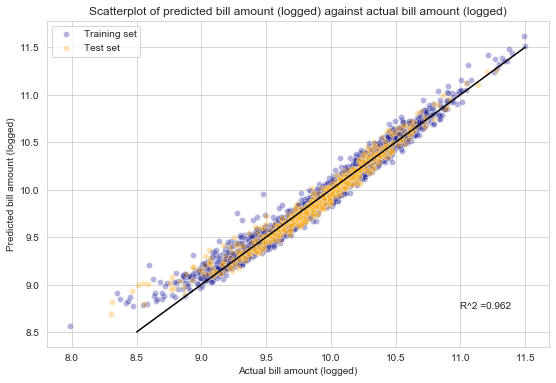

In [72]:
"""Elastic net just using new variables after trasformation"""
new_cols = ['symptom_5', 'resident_status_Foreigner', 'race_Malay',
       'medical_history_1',  'medical_history_6',
       'race_Chinese', 'resident_status_PR', 'num_of_diseases',
       'num_of_symptoms', 'sqrt_age', 'std_weight', 'std_lab_result_2']

elastic_generator(new_cols)

Interestingly, there was no overfitting! The model did not perform much worse when fitting test set to model. The decrease in score was marginal. Also, It's nice to see the RMSLE function kicking in here! Although any over-prediction is not that substantial anyways.

Removing number of diseases
scores of cross-validation = [0.008 0.007 0.008 0.008 0.008]
mean scores of cross-validation = 0.00802
rmsle of training = 0.00797
rmsle of test = 0.00896


Removing lab results 2
scores of cross-validation = [0.008 0.007 0.008 0.008 0.008]
mean scores of cross-validation = 0.00802
rmsle of training = 0.00797
rmsle of test = 0.00896


Removing medical history 6
scores of cross-validation = [0.011 0.01  0.011 0.011 0.01 ]
mean scores of cross-validation = 0.0106
rmsle of training = 0.01054
rmsle of test = 0.01128


Removing just lab results 2
scores of cross-validation = [0.008 0.007 0.007 0.008 0.008]
mean scores of cross-validation = 0.00767
rmsle of training = 0.00762
rmsle of test = 0.00856




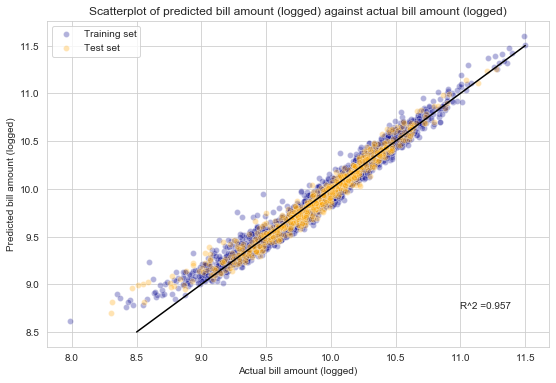

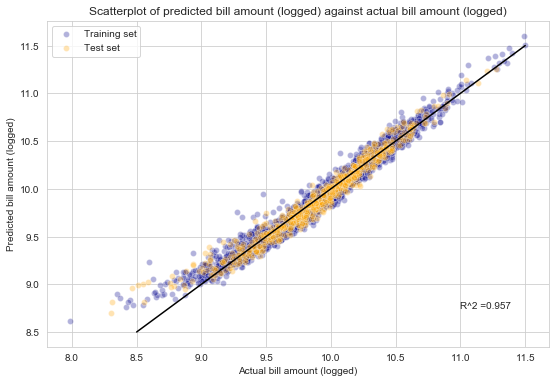

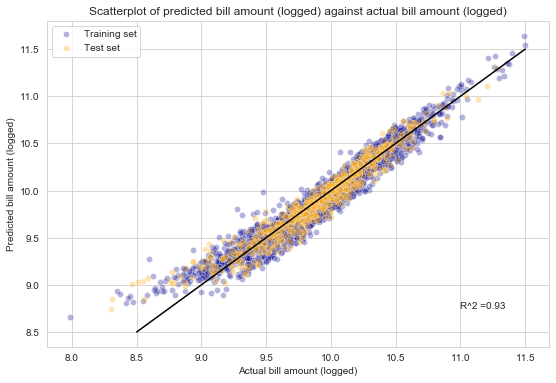

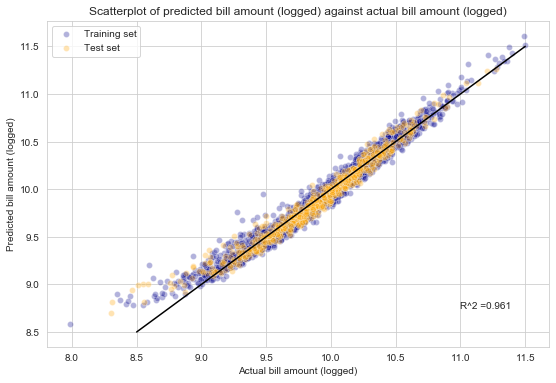

In [73]:
"""Removing the weakest variables as seen from random forest using best_cols"""
print("Removing number of diseases")
remove_num_diseases = ['symptom_5', 'resident_status_Foreigner', 'race_Malay',
                       'age_at_admission', 'medical_history_1', 'weight', 'medical_history_6',
                       'race_Chinese', 'lab_result_2', 'resident_status_PR',
                       'num_of_symptoms']

elastic_generator(remove_num_diseases)
print("\n")

print("Removing lab results 2")
remove_lab2 = ['symptom_5', 'resident_status_Foreigner', 'race_Malay',
                   'age_at_admission', 'medical_history_1', 'weight', 'medical_history_6',
                   'race_Chinese', 'resident_status_PR',
                   'num_of_symptoms']

elastic_generator(remove_lab2)
print("\n")

print("Removing medical history 6")
remove_med6 = ['symptom_5', 'resident_status_Foreigner', 'race_Malay',
               'age_at_admission', 'medical_history_1', 'weight', 'race_Chinese', 'resident_status_PR',
               'num_of_symptoms']

elastic_generator(remove_med6)
print("\n")

print("Removing just lab results 2")
remove_lab2_only = ['symptom_5', 'resident_status_Foreigner', 'race_Malay',
                       'age_at_admission', 'medical_history_1', 'weight', 'medical_history_6',
                       'race_Chinese', 'num_of_diseases', 'resident_status_PR',
                       'num_of_symptoms']

elastic_generator(remove_lab2_only)
print("\n")

So I tried to reduce the side of the model further by removing the vanilla variables which were found to be the least important from Random Forest. I removed 3 variables of the least importance. I found out that the scores obtained from removing just number of diseases and from removing both number of diseases and lab result 2 were exactly the same. This means that lab result 2 is not as important as it seems. The 4th run was to just remove lab result 2. As seen above, it results in the same R^2 although the RMSLE scores was slightly poorer (increased). This means that we can remove lab_result_2, if we wanted a simpler model.


In view of time, this is where I will stop my analysis. 

# End of Jupyter Notebook